# Visualization of Platemaps

__Author: Runxi Shen__

__Date: 2025-04-29__

This is a notebook that helps draw up the distribution of alleles and their types on a 384-well platemap to help me better understand the experimental set-ups of different batches and how we need to adjust our analyses pipeline to accommodate the changes accordingly.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
%matplotlib inline
sys.path.append("../../..")
from utils import *

## Disable truncation globally
pl.Config.set_tbl_rows(20)  # Show all rows
pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]
# CTRLS = TC + NC + PC

## Metadata

In [49]:
meta_dat_df = pd.read_csv("../../inputs/corrected_metadata/2025_03_batch15-16/B15-16_Metadata_041125.csv")
meta_dat_df
# meta_dat_df[meta_dat_df["symbol"]=="TPM1"]

symbol     gene_allele   source_plate source_well  source_numb  \
0     AP2S1           AP2S1     FV_reLR_01         G01          7.0   
1     AP2S1  AP2S1_Arg15Cys  VUSmut_GDEh06         B04         26.0   
2     AP2S1  AP2S1_Arg15His  VUSmut_GDEh06         G05         39.0   
3     APOA1           APOA1    DisWTGDEh03         C05         35.0   
4     APOA1  APOA1_Arg34Leu  VUSmut_GDEh09         C12         91.0   
..      ...             ...            ...         ...          ...   
318     ALK  ALK_Arg1275Gln  527 Controls          NaN          NaN   
319   MAPK9          MAPK9_  527 Controls          NaN          NaN   
320    RHEB           RHEB_  527 Controls          NaN          NaN   
321   SLIRP          SLIRP_  527 Controls          NaN          NaN   
322  PRKACB         PRKACB_  527 Controls          NaN          NaN   

        dest_plate dest_well  dest_numb imaging_well imaging_plate_R1  ...  \
0    FVrry_P05_Q01       A01          1          A01     B15A1A2P1_R1  ...   
1    FVrry_P05_Q01       B01          2          C01     B15A1A2P1_R1  ...   
2    FVrry_P05_Q01       C01          3          E01     B15A1A2P1_R1  ...   
3    FVrry_P05_Q01       D01          4          G01     B15A1A2P1_R1  ...   
4    FVrry_P05_Q01       E01          5          I01     B15A1A2P1_R1  ...   
..             ...       ...        ...          ...              ...  ...   
318  FVrry_P05_Q04       E05         37          J10     B15A1A2P1_R1  ...   
319  FVrry_P05_Q04       F07         54          L14     B15A1A2P1_R1  ...   
320  FVrry_P05_Q04       E08         61          J16     B15A1A2P1_R1  ...   
321  FVrry_P05_Q04       D09         68          H18     B15A1A2P1_R1  ...   
322  FVrry_P05_Q04       C10         75          F20     B15A1A2P1_R1  ...   

    nt_change_cdna aa_change  ccsb_mutation_id hgmd_ID clinvar_allele_ID  \
0              NaN       NaN               NaN     NaN               NaN   
1            43C>T  Arg15Cys          215314.0     NaN               NaN   
2            44G>A  Arg15His          215316.0     NaN               NaN   
3              NaN       NaN               NaN     NaN               NaN   
4           101G>T  Arg34Leu          215445.0     NaN               NaN   
..             ...       ...               ...     ...               ...   
318            NaN       NaN               NaN     NaN               NaN   
319            NaN       NaN               NaN     NaN               NaN   
320            NaN       NaN               NaN     NaN               NaN   
321            NaN       NaN               NaN     NaN               NaN   
322            NaN       NaN               NaN     NaN               NaN   

     clinvar_clinical_significance  sequencing_confidence   gene  allele  \
0                              NaN                  high   AP2S1     NaN   
1                              NaN                    NaN    NaN     NaN   
2                              NaN                    NaN    NaN     NaN   
3                              NaN                    NaN    NaN     NaN   
4                              NaN                    NaN    NaN     NaN   
..                             ...                    ...    ...     ...   
318                            NaN                    NaN    NaN     NaN   
319                            NaN                    NaN    NaN     NaN   
320                            NaN                    NaN    NaN     NaN   
321                            NaN                    NaN    NaN     NaN   
322                            NaN                    NaN    NaN     NaN   

    final_gene_allele  
0               AP2S1  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
..                ...  
318               NaN  
319               NaN  
320               NaN  
321               NaN  
322               NaN  

[323 rows x 23 columns]

In [ ]:
meta_dat_df["gene_allele"] = meta_dat_df["gene_allele"].apply(lambda x: x[:-1] if type(x)==str and x.endswith("_") else x)
meta_dat_df["gene_symbol"] = meta_dat_df["gene_allele"].apply(lambda x: x.split("_")[0] if type(x)==str else x)
# all(meta_dat_df["gene_symbol"]==meta_dat_df["symbol"])
meta_dat_df[meta_dat_df["gene_symbol"]!=meta_dat_df["symbol"]]

meta_dat_df.insert(0, "plate_map_name", "B15A1A2_P1")
meta_dat_df.insert(1, "well_position", meta_dat_df["imaging_well"])
# meta_dat_df.to_csv("../../inputs/platemaps/2025_03_17_Batch_15/platemap/B15A1A2_P1.txt", sep="\t", index=False)

meta_dat_df["plate_map_name"] = "B16A1A2_P1"
# meta_dat_df.to_csv("../../inputs/platemaps/2025_03_17_Batch_16/platemap/B16A1A2_P1.txt", sep="\t", index=False)

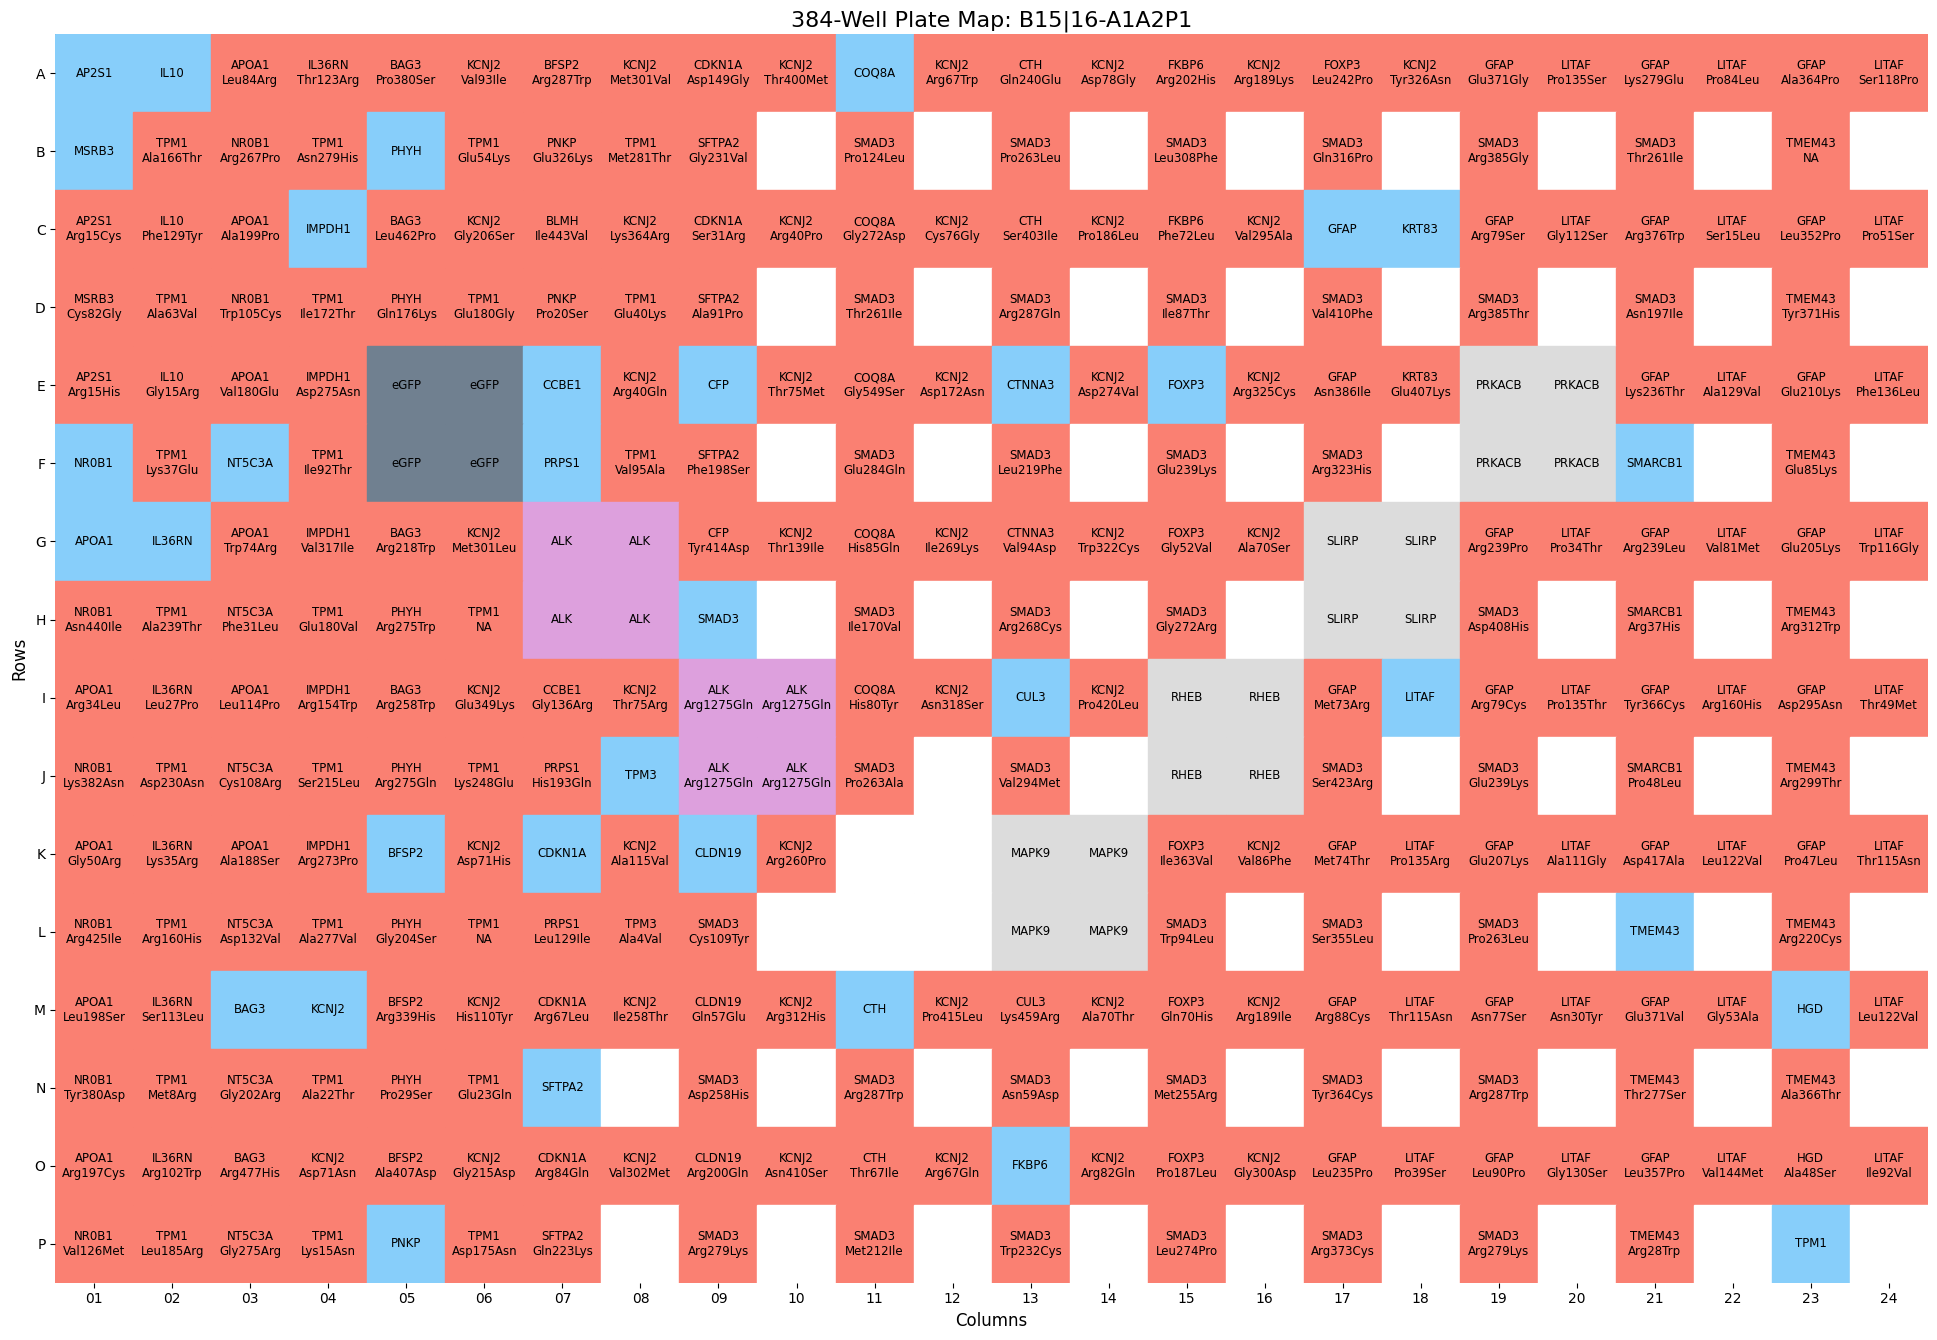

shape: (384, 32)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ row ┆ col ┆ val ┆ row ┆ col ┆ pla ┆ wel ┆ sym ┆ gen ┆ sou ┆ sou ┆ sou ┆ des ┆ des ┆ des ┆ ima ┆ ima ┆ ima ┆ nod ┆ orf ┆ nt_ ┆ aa_ ┆ ccs ┆ hgm ┆ cli ┆ cli ┆ seq ┆ gen ┆ all ┆ fin ┆ gen ┆ lab │
│ --- ┆ --- ┆ ue  ┆ _la ┆ _la ┆ te_ ┆ l_p ┆ bol ┆ e_a ┆ rce ┆ rce ┆ rce ┆ t_p ┆ t_w ┆ t_n ┆ gin ┆ gin ┆ gin ┆ e_t ┆ _id ┆ cha ┆ cha ┆ b_m ┆ d_I ┆ nva ┆ nva ┆ uen ┆ e   ┆ ele ┆ al_ ┆ e_s ┆ el  │
│ u32 ┆ str ┆ --- ┆ bel ┆ bel ┆ map ┆ osi ┆ --- ┆ lle ┆ _pl ┆ _we ┆ _nu ┆ lat ┆ ell ┆ umb ┆ g_w ┆ g_p ┆ g_p ┆ ype ┆ _wt ┆ nge ┆ nge ┆ uta ┆ D   ┆ r_a ┆ r_c ┆ cin ┆ --- ┆ --- ┆ gen ┆ ymb ┆ --- │
│     ┆     ┆ str ┆ --- ┆ --- ┆ _na ┆ tio ┆ str ┆ le  ┆ ate ┆ ll  ┆ mb  ┆ e   ┆ --- ┆ --- ┆ ell ┆ lat ┆ lat ┆ --- ┆ --- ┆ _cd ┆ --- ┆ tio ┆ --- ┆ lle ┆ lin ┆ g_c ┆ str ┆ str ┆ e_a ┆ ol  ┆ str │
│     ┆     ┆     ┆ str ┆ str ┆ me  ┆ n   ┆     ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ str ┆ i64 ┆ --- ┆ e_R ┆ e_R ┆ str ┆ f64 ┆ na  ┆ str ┆ n_i ┆ f64 ┆ le_ ┆ ica ┆ onf ┆     ┆     ┆ lle ┆ --- ┆     │
│     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆ str ┆ str ┆ str ┆ f64 ┆ str ┆     ┆     ┆ str ┆ 1   ┆ 2   ┆     ┆     ┆ --- ┆     ┆ d   ┆     ┆ ID  ┆ l_s ┆ ide ┆     ┆     ┆ le  ┆ str ┆     │
│     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆     ┆ str ┆     ┆ --- ┆     ┆ --- ┆ ign ┆ nce ┆     ┆     ┆ --- ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆     ┆     ┆ f64 ┆     ┆ f64 ┆ ifi ┆ --- ┆     ┆     ┆ str ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ can ┆ str ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ce  ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ 0   ┆ 01  ┆     ┆ A   ┆ 01  ┆ B16 ┆ A01 ┆ AP2 ┆ AP2 ┆ FV_ ┆ G01 ┆ 7.0 ┆ FVr ┆ A01 ┆ 1   ┆ A01 ┆ B15 ┆ B16 ┆ dis ┆ 498 ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ hig ┆ AP2 ┆ nul ┆ AP2 ┆ AP2 ┆ AP2 │
│     ┆     ┆     ┆     ┆     ┆ A1A ┆     ┆ S1  ┆ S1  ┆ reL ┆     ┆     ┆ ry_ ┆     ┆     ┆     ┆ A1A ┆ A1A ┆ eas ┆ 3.0 ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ h   ┆ S1  ┆ l   ┆ S1  ┆ S1  ┆ S1  │
│     ┆     ┆     ┆     ┆     ┆ 2_P ┆     ┆     ┆     ┆ R_0 ┆     ┆     ┆ P05 ┆     ┆     ┆     ┆ 2P1 ┆ 2P1 ┆ e_w ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆ 1   ┆     ┆     ┆     ┆ 1   ┆     ┆     ┆ _Q0 ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆ t   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 1   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ 1   ┆ 01  ┆     ┆ B   ┆ 01  ┆ B16 ┆ B01 ┆ MSR ┆ MSR ┆ FV_ ┆ G03 ┆ 23. ┆ FVr ┆ A01 ┆ 1   ┆ B01 ┆ B15 ┆ B16 ┆ dis ┆ 114 ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ ver ┆ MSR ┆ Cys ┆ MSR ┆ MSR ┆ MSR │
│     ┆     ┆     ┆     ┆     ┆ A1A ┆     ┆ B3  ┆ B3  ┆ reL ┆     ┆ 0   ┆ ry_ ┆     ┆     ┆     ┆ A1A ┆

In [33]:
meta_dat_df = pl.DataFrame(meta_dat_df)
plot_platemap(meta_dat_df, plate_name="B15|16-A1A2P1", well_pos_col="imaging_well")

## Metadata QC

In [3]:
meta_dat_df = pd.read_csv("../../inputs/corrected_metadata/2025_03_batch15-16/B15B16_Metadata_seq_update_050625.csv")
mask = meta_dat_df['final_gene_allele'].notna() & (meta_dat_df['final_gene_allele'] != meta_dat_df['gene_allele'])
# meta_dat_df.loc[mask,:]
meta_dat_df.loc[mask, 'gene_allele'] = meta_dat_df.loc[mask, 'final_gene_allele']
meta_dat_df.loc[mask,:]

# meta_dat_df[meta_dat_df["symbol"]=="TPM1"]

symbol      gene_allele source_plate source_well  source_numb  \
96      IL10            KCNJ2   FV_reLR_01         C02         11.0   
99    IL36RN   KCNJ2_Glu17Arg   FV_reLR_01         E03         21.0   
192    MSRB3   MSRB3_Cys82Gly   FV_reLR_01         G03         23.0   
214     PHYH  NR0B1_Trp105Cys   FV_reLR_02         A11         81.0   
218    PRPS1   TPM1_Asp175Asn   FV_reLR_01         E05         37.0   
274  SMARCB1   TPM1_Arg238Trp   FV_reLR_01         D03         20.0   
301     TPM1             TPM1   FV_reLR_01         G10         79.0   
311     TPM1             TPM1   FV_reLR_02         B01          2.0   

        dest_plate dest_well  dest_numb imaging_well imaging_plate_R1  ...  \
96   FVrry_P05_Q02       A01          1          A02     B15A1A2P1_R1  ...   
99   FVrry_P05_Q02       D01          4          G02     B15A1A2P1_R1  ...   
192  FVrry_P05_Q03       A01          1          B01     B15A1A2P1_R1  ...   
214  FVrry_P05_Q03       G03         23          N05     B15A1A2P1_R1  ...   
218  FVrry_P05_Q03       C04         27          F07     B15A1A2P1_R1  ...   
274  FVrry_P05_Q03       C11         83          F21     B15A1A2P1_R1  ...   
301  FVrry_P05_Q04       F02         14          L04     B15A1A2P1_R1  ...   
311  FVrry_P05_Q04       H03         24          P06     B15A1A2P1_R1  ...   

    nt_change_cdna  aa_change  ccsb_mutation_id hgmd_ID clinvar_allele_ID  \
96             NaN        NaN               NaN     NaN               NaN   
99             NaN        NaN               NaN     NaN               NaN   
192            NaN        NaN               NaN     NaN               NaN   
214          85C>T   Pro29Ser            3351.0     NaN               NaN   
218            NaN        NaN               NaN     NaN               NaN   
274            NaN        NaN               NaN     NaN               NaN   
301         830C>T  Ala277Val          201749.0     NaN               NaN   
311         523G>A  Asp175Asn            8952.0     NaN               NaN   

     clinvar_clinical_significance  sequencing_confidence   gene     allele  \
96                             NaN               verified  KCNJ2        NaN   
99                             NaN              verified   KCNJ2   Glu17Arg   
192                            NaN               verified  MSRB3   Cys82Gly   
214                            NaN                  high   NR0B1  Trp105Cys   
218                            NaN              verified    TPM1  Asp175Asn   
274                            NaN              verified    TPM1  Arg238Trp   
301                            NaN              verified    TPM1        NaN   
311                            NaN              verified    TPM1        NaN   

    final_gene_allele  
96              KCNJ2  
99     KCNJ2_Glu17Arg  
192    MSRB3_Cys82Gly  
214   NR0B1_Trp105Cys  
218    TPM1_Asp175Asn  
274    TPM1_Arg238Trp  
301              TPM1  
311              TPM1  

[8 rows x 23 columns]

In [4]:
meta_dat_df["gene_allele"] = meta_dat_df["gene_allele"].apply(lambda x: x[:-1] if type(x)==str and x.endswith("_") else x)
meta_dat_df["gene_symbol"] = meta_dat_df["gene_allele"].apply(lambda x: x.split("_")[0] if type(x)==str else x)
meta_dat_df["symbol"] = meta_dat_df["gene_symbol"]

## mask_null_node
# meta_dat_df["node_type"].unique()
mask_null_node = meta_dat_df["gene_allele"].isna() | meta_dat_df["gene_allele"].str.contains("null") | meta_dat_df["gene_allele"].str.contains("_NA")
meta_dat_df.loc[mask_null_node,]

meta_dat_df.loc[mask_null_node, "symbol"] = np.nan
meta_dat_df.loc[mask_null_node, "gene_allele"] = np.nan
meta_dat_df.loc[mask_null_node, "node_type"] = np.nan

mask_allele = meta_dat_df['gene_allele'].notna() & meta_dat_df["gene_allele"].str.contains("_")
meta_dat_df.loc[mask_allele, "node_type"] = "allele"

mask_wt = (meta_dat_df['gene_allele']==meta_dat_df['symbol']) & (meta_dat_df['node_type']=="allele")
meta_dat_df.loc[mask_wt, "node_type"] = "disease_wt"

# assert(all(meta_dat_df["gene_symbol"]==meta_dat_df["symbol"]))
meta_dat_df[meta_dat_df["gene_symbol"]!=meta_dat_df["symbol"]]
meta_dat_df.drop(columns=["gene","allele","final_gene_allele","gene_symbol"], inplace=True)

meta_dat_df.insert(0, "plate_map_name", "B15A1A2P1_R1")
meta_dat_df.insert(1, "well_position", meta_dat_df["imaging_well"])
os.makedirs("../../outputs/corrected_platemaps/2025_03_17_Batch_15/platemap")
meta_dat_df.to_csv("../../outputs/corrected_platemaps/2025_03_17_Batch_15/platemap/B15A1A2P1_R1.txt", sep="\t", index=False)

meta_dat_df["plate_map_name"] = "B16A1A2P1_R1"
os.makedirs("../../outputs/corrected_platemaps/2025_03_17_Batch_16/platemap")
meta_dat_df.to_csv("../../outputs/corrected_platemaps/2025_03_17_Batch_16/platemap/B16A1A2P1_R1.txt", sep="\t", index=False)

In [5]:
meta_dat_df["node_type"].unique()

array(['disease_wt', 'allele', 'TC', 'PC', nan, 'NC'], dtype=object)

In [6]:
# meta_dat_df[meta_dat_df["symbol"]=="TPM1"]

In [7]:
result_count = meta_dat_df.groupby(['node_type', 'gene_allele']).size().reset_index(name='count')
result_count[result_count["node_type"]=="allele"]

node_type      gene_allele  count
6      allele   ALK_Arg1275Gln      4
7      allele   AP2S1_Arg15Cys      1
8      allele   AP2S1_Arg15His      1
9      allele  APOA1_Ala188Ser      1
10     allele  APOA1_Ala199Pro      1
..        ...              ...    ...
250    allele   TPM1_Met281Thr      1
251    allele     TPM1_Met8Arg      1
252    allele   TPM1_Ser215Leu      1
253    allele    TPM1_Val95Ala      1
254    allele     TPM3_Ala4Val      1

[249 rows x 3 columns]

In [45]:
meta_dat_df.filter(pl.col("gene_allele").is_in(["TPM1_NA"]))

shape: (2, 22)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ pla ┆ wel ┆ sym ┆ gen ┆ sou ┆ sou ┆ sou ┆ des ┆ des ┆ des ┆ ima ┆ ima ┆ ima ┆ nod ┆ orf ┆ nt_ ┆ aa_ ┆ ccs ┆ hgm ┆ cli ┆ cli ┆ seq │
│ te_ ┆ l_p ┆ bol ┆ e_a ┆ rce ┆ rce ┆ rce ┆ t_p ┆ t_w ┆ t_n ┆ gin ┆ gin ┆ gin ┆ e_t ┆ _id ┆ cha ┆ cha ┆ b_m ┆ d_I ┆ nva ┆ nva ┆ uen │
│ map ┆ osi ┆ --- ┆ lle ┆ _pl ┆ _we ┆ _nu ┆ lat ┆ ell ┆ umb ┆ g_w ┆ g_p ┆ g_p ┆ ype ┆ _wt ┆ nge ┆ nge ┆ uta ┆ D   ┆ r_a ┆ r_c ┆ cin │
│ _na ┆ tio ┆ str ┆ le  ┆ ate ┆ ll  ┆ mb  ┆ e   ┆ --- ┆ --- ┆ ell ┆ lat ┆ lat ┆ --- ┆ --- ┆ _cd ┆ --- ┆ tio ┆ --- ┆ lle ┆ lin ┆ g_c │
│ me  ┆ n   ┆     ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ str ┆ i64 ┆ --- ┆ e_R ┆ e_R ┆ str ┆ f64 ┆ na  ┆ str ┆ n_i ┆ f64 ┆ le_ ┆ ica ┆ onf │
│ --- ┆ --- ┆     ┆ str ┆ str ┆ str ┆ f64 ┆ str ┆     ┆     ┆ str ┆ 1   ┆ 2   ┆     ┆     ┆ --- ┆     ┆ d   ┆     ┆ ID  ┆ l_s ┆ ide │
│ str ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆     ┆ str ┆     ┆ --- ┆     ┆ --- ┆ ign ┆ nce │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆     ┆     ┆ f64 ┆     ┆ f64 ┆ ifi ┆ --- │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ can ┆ str │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ce  ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ B16 ┆ H06 ┆ TPM ┆ TPM ┆ VUS ┆ H10 ┆ 80. ┆ FVr ┆ D03 ┆ 20  ┆ H06 ┆ B15 ┆ B16 ┆ all ┆ 472 ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul │
│ A1A ┆     ┆ 1   ┆ 1_N ┆ mut ┆     ┆ 0   ┆ ry_ ┆     ┆     ┆     ┆ A1A ┆ A1A ┆ ele ┆ 3.0 ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   │
│ 2P1 ┆     ┆     ┆ A   ┆ _GD ┆     ┆     ┆ P05 ┆     ┆     ┆     ┆ 2P1 ┆ 2P1 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ _R1 ┆     ┆     ┆     ┆ Eh0 ┆     ┆     ┆ _Q0 ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆ 8   ┆     ┆     ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ B16 ┆ L06 ┆ TPM ┆ TPM ┆ VUS ┆ D04 ┆ 28. ┆ FVr ┆ F03 ┆ 22  ┆ L06 ┆ B15 ┆ B16 ┆ all ┆ 472 ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul ┆ nul │
│ A1A ┆     ┆ 1   ┆ 1_N ┆ mut ┆     ┆ 0   ┆ ry_ ┆     ┆     ┆     ┆ A1A ┆ A1A ┆ ele ┆ 3.0 ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   ┆ l   │
│ 2P1 ┆     ┆     ┆ A   ┆ _GD ┆     ┆     ┆ P05 ┆     ┆     ┆     ┆ 2P1 ┆ 2P1 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│ _R1 ┆     ┆     ┆     ┆ Eh0 ┆     ┆     ┆ _Q0 ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆ 9   ┆     ┆     ┆ 4   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
└─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┴─────┘

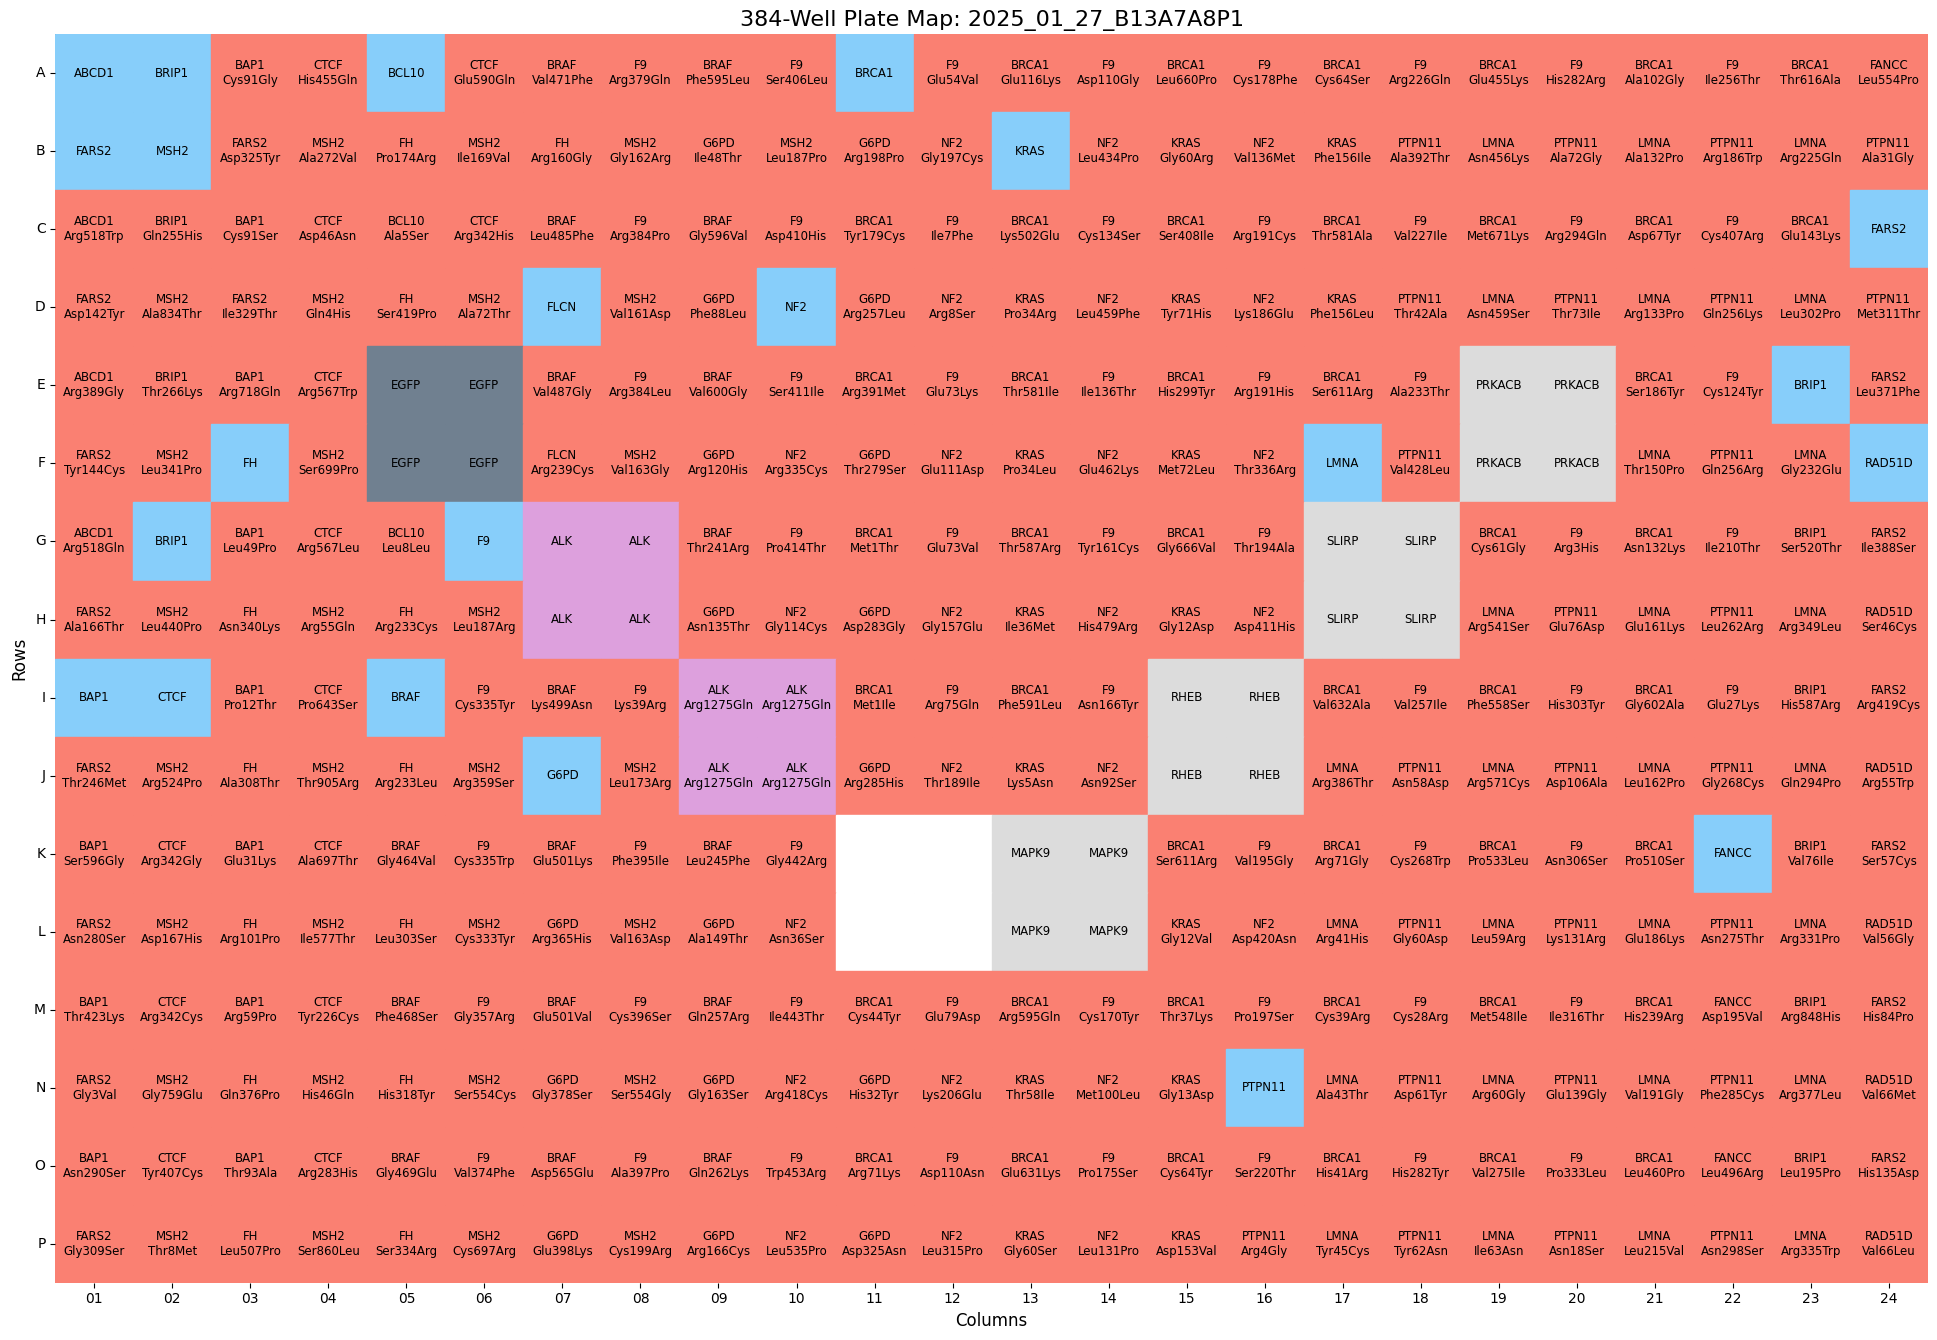

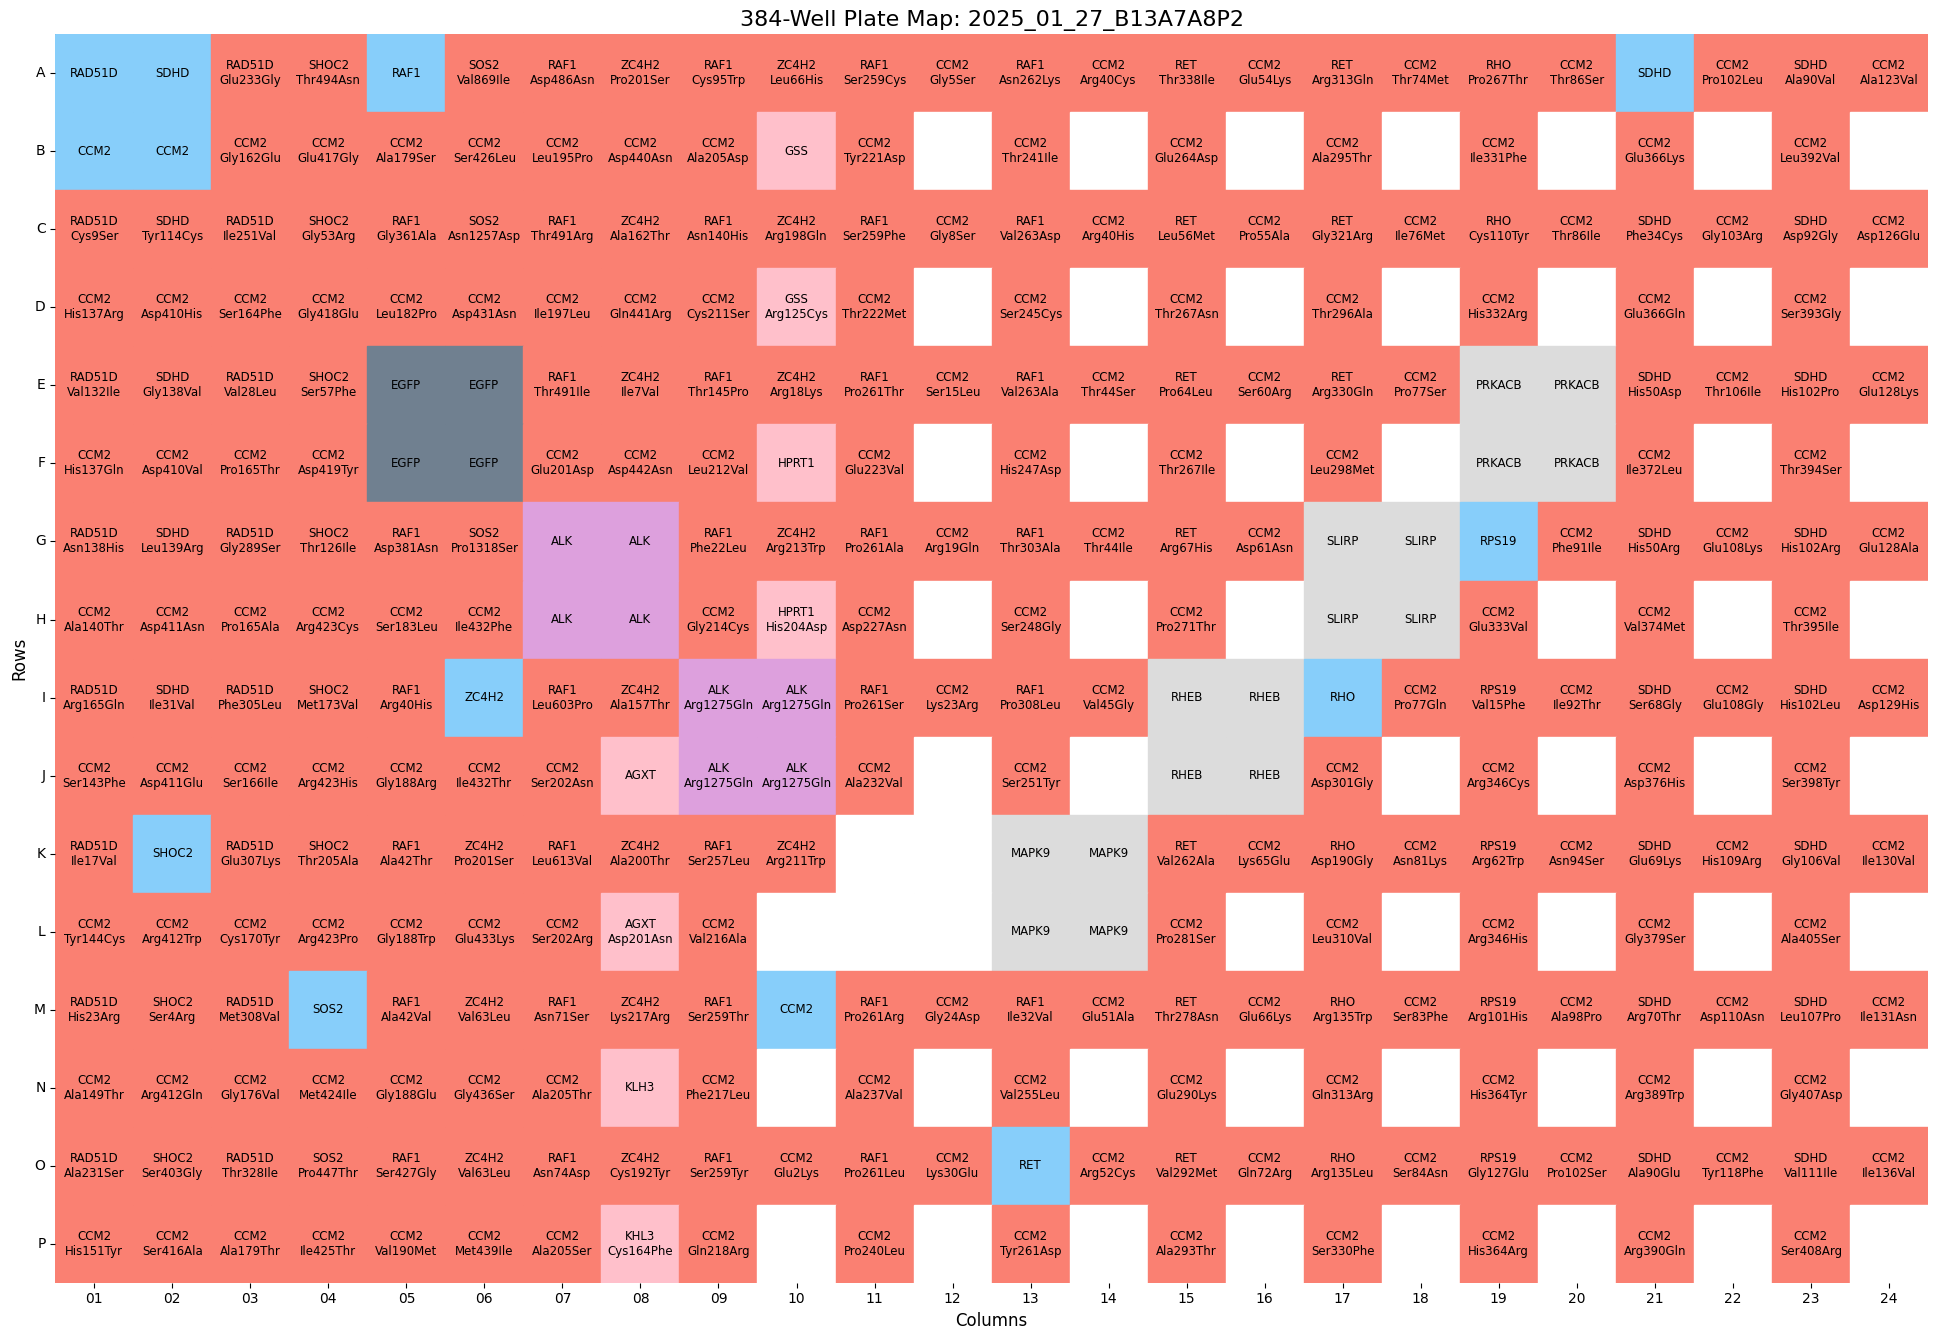

In [34]:
## clean up the meta file a little bit
## remove the unwanted '_' in the columns
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
      .then(pl.col("gene_allele").str.replace(r"_$", ""))
      .otherwise(pl.col("gene_allele"))
      .alias("gene_allele") # Remove trailing "_"
)
## remove unnecessary weired chars
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.col("symbol").str.replace_all(r"[^a-zA-Z0-9_]", ""),#.alias("symbol"), ## remove unnessary chars
    pl.col("gene_allele").str.replace_all(r"[^a-zA-Z0-9_]", ""),#.alias("gene_allele"), ## remove unnessary chars
)
## correct eGFP to EGFP
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.col("symbol").str.replace('eGFP', 'EGFP'),#.alias("symbol"),
    pl.col("gene_allele").str.replace('eGFP', 'EGFP')#.alias("gene_allele")
)

plate_grid = plot_platemap(
    meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P1_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position")), 
    "2025_01_27_B13A7A8P1")

plate_grid = plot_platemap(
    meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P2_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position")), 
    "2025_01_27_B13A7A8P2")

In [35]:
# meta_dat_b134_corrected.write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/B13-14_metadata_update_cleaned.csv", separator=",")

### Old damaged platemaps

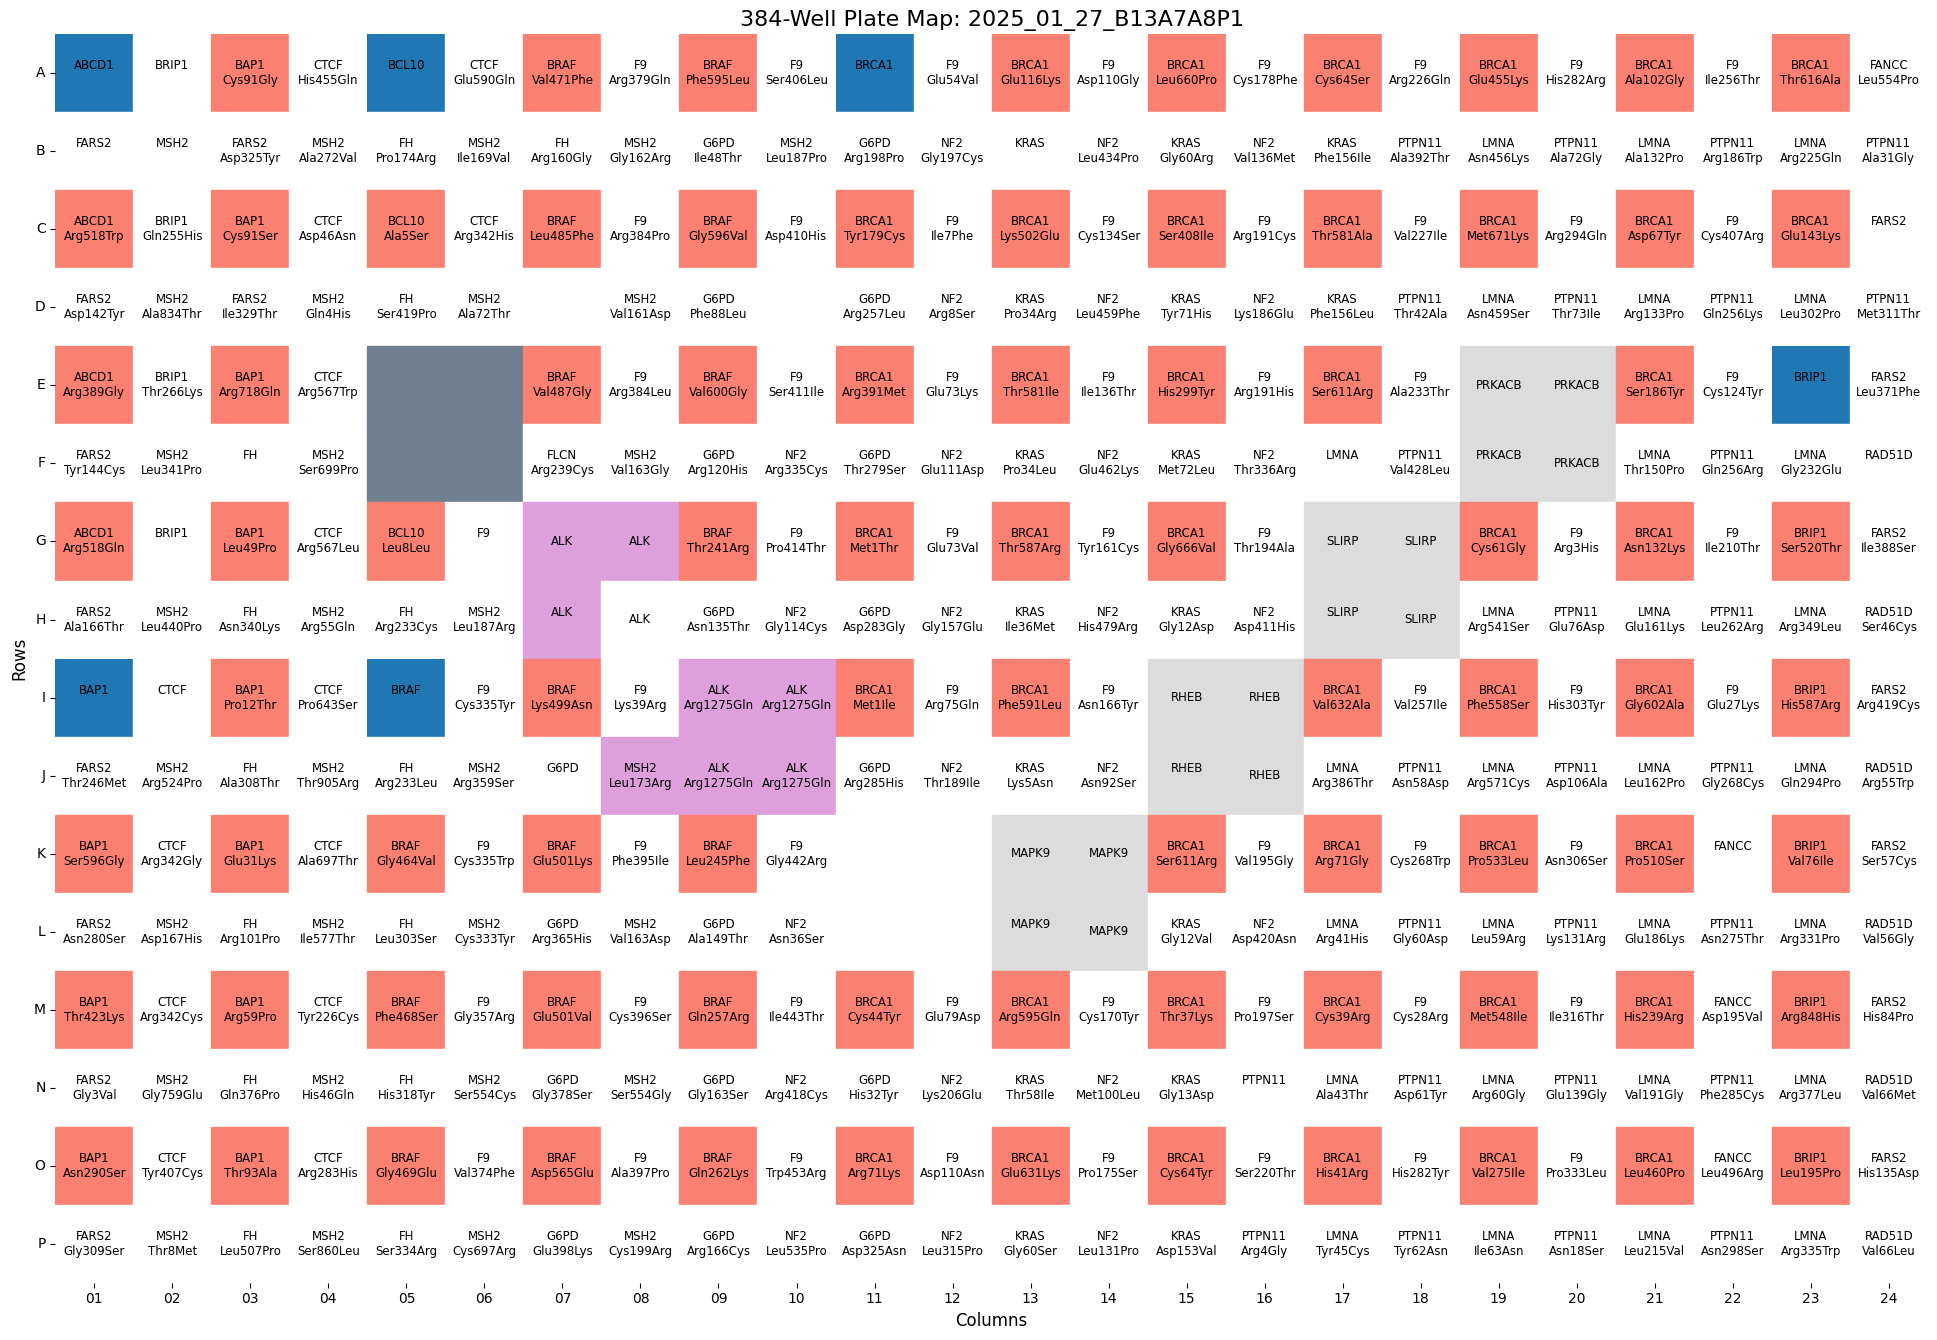

In [25]:
# batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P1_T1.txt"
plate_map = pl.read_csv(Path(batch_dir_13) / Path(plate_map_id), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

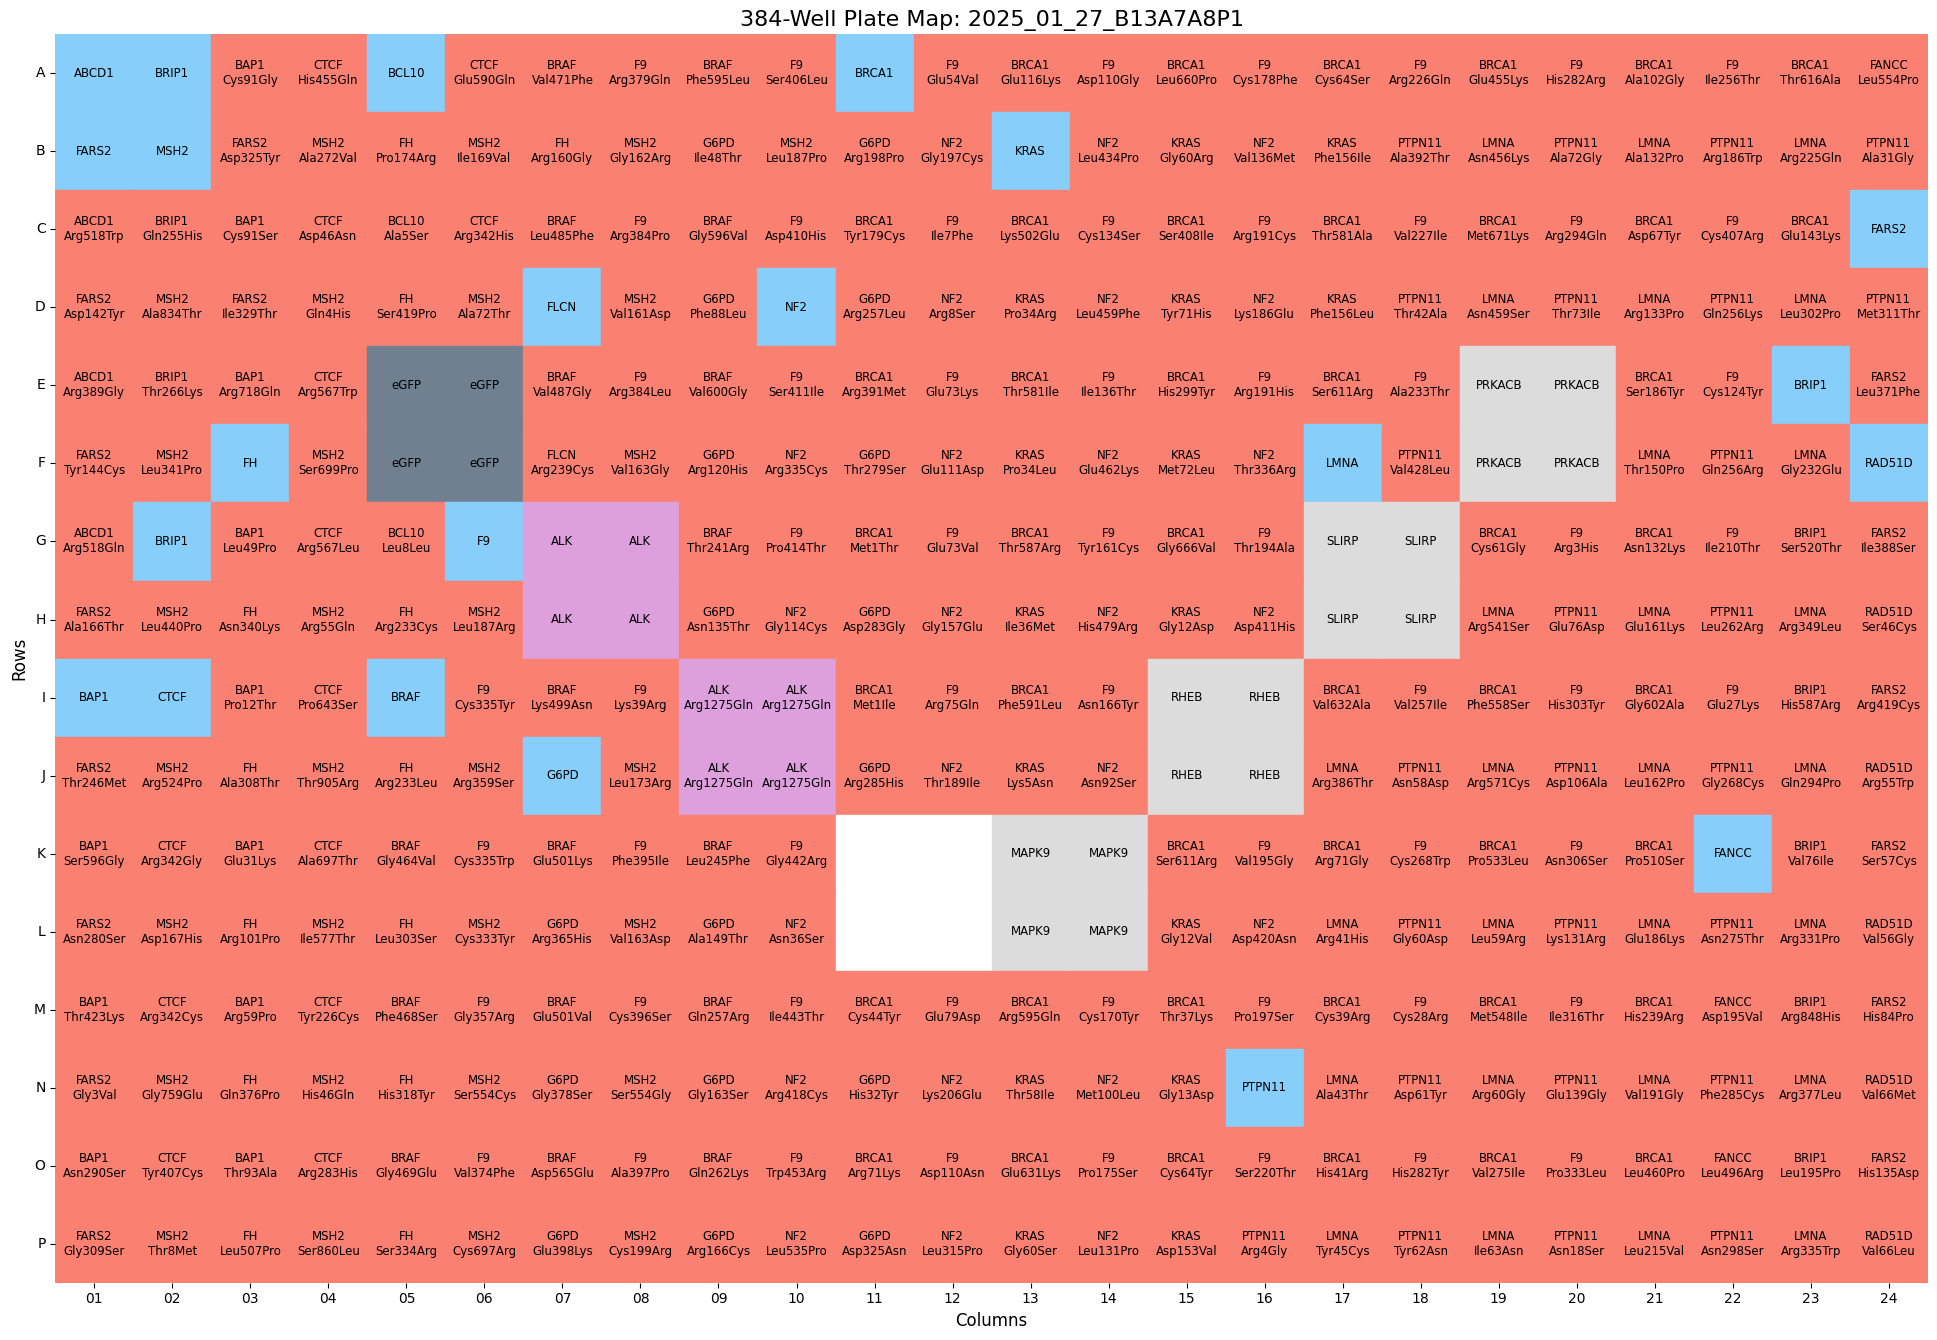

In [26]:
plate_map = plate_map.with_columns(
    # pl.col("symbol").alias("symbol_original"),
    # ## clean up the symbols first
    # pl.col("symbol").str.replace_all(r'[^a-zA-Z0-9]', '').alias("symbol"),
    # Condition 1: Keep "_" as is or fill the symbol if gene allele is missing by accident
    pl.when((pl.col("gene_allele")=="_")|(pl.col("gene_allele").is_null()&pl.col("symbol").is_not_null()))
        .then(pl.col("symbol"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.when((pl.col("gene_allele").is_in(PC))) #(pl.col("node_type").is_null())
        .then(pl.lit("PC"))
        .when((pl.col("gene_allele").is_in(NC))) #(pl.col("node_type").is_null())
        .then(pl.lit("NC"))
        # .when((pl.col("gene_allele").is_in(cPC))) #(pl.col("node_type").is_null())
        # .then(pl.lit("cPC"))
        .when(pl.col("aa_change").is_not_null()) ## manually handle a special case
        .then(pl.lit("allele"))
        .when((pl.col("aa_change").is_null())&(pl.col("symbol").is_not_null())&(~pl.col("symbol").is_in(PC))&(~pl.col("symbol").is_in(NC))&(~pl.col("symbol").str.to_uppercase().is_in(TC))) ## (pl.col("node_type").is_null())&
        .then(pl.lit("disease_wt"))
        .when(pl.col("node_type").is_not_null())
        .then(pl.col("node_type"))
        .when((pl.col("symbol").str.to_uppercase().is_in(TC))) #(pl.col("node_type").is_null())
        .then(pl.lit("TC"))
        .alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

In [27]:
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")

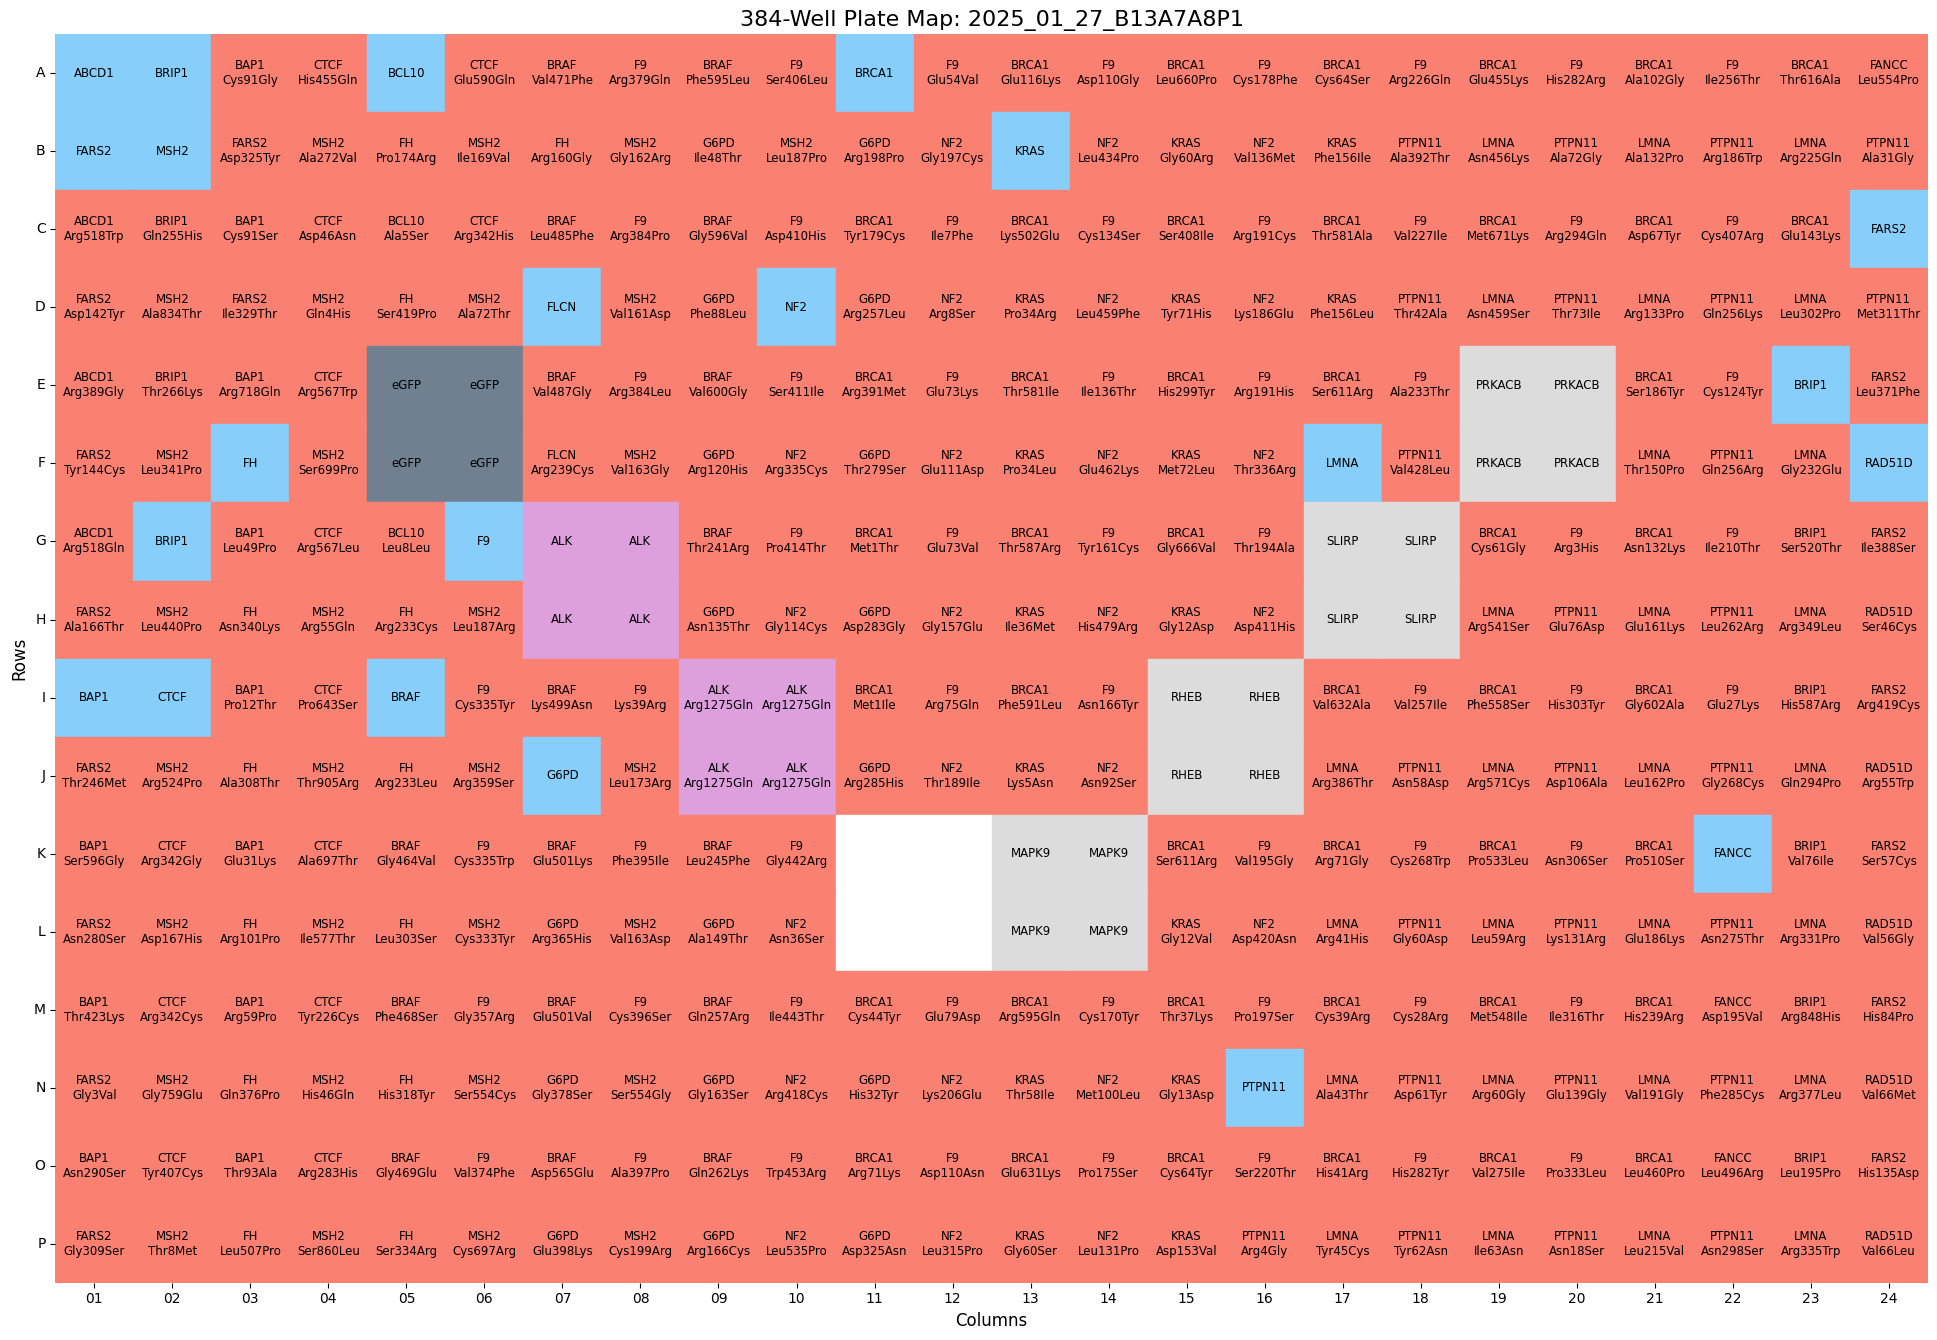

In [4]:
# plate_map.filter(pl.col("well_position")=="E19")
# plate_map.filter(pl.col("well_position")=="E19")
# plate_map.filter(pl.col("symbol")=="FLCN")
# plate_map.filter(pl.col("symbol").str.to_uppercase().is_in(TC))

batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P1_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

### Second plate

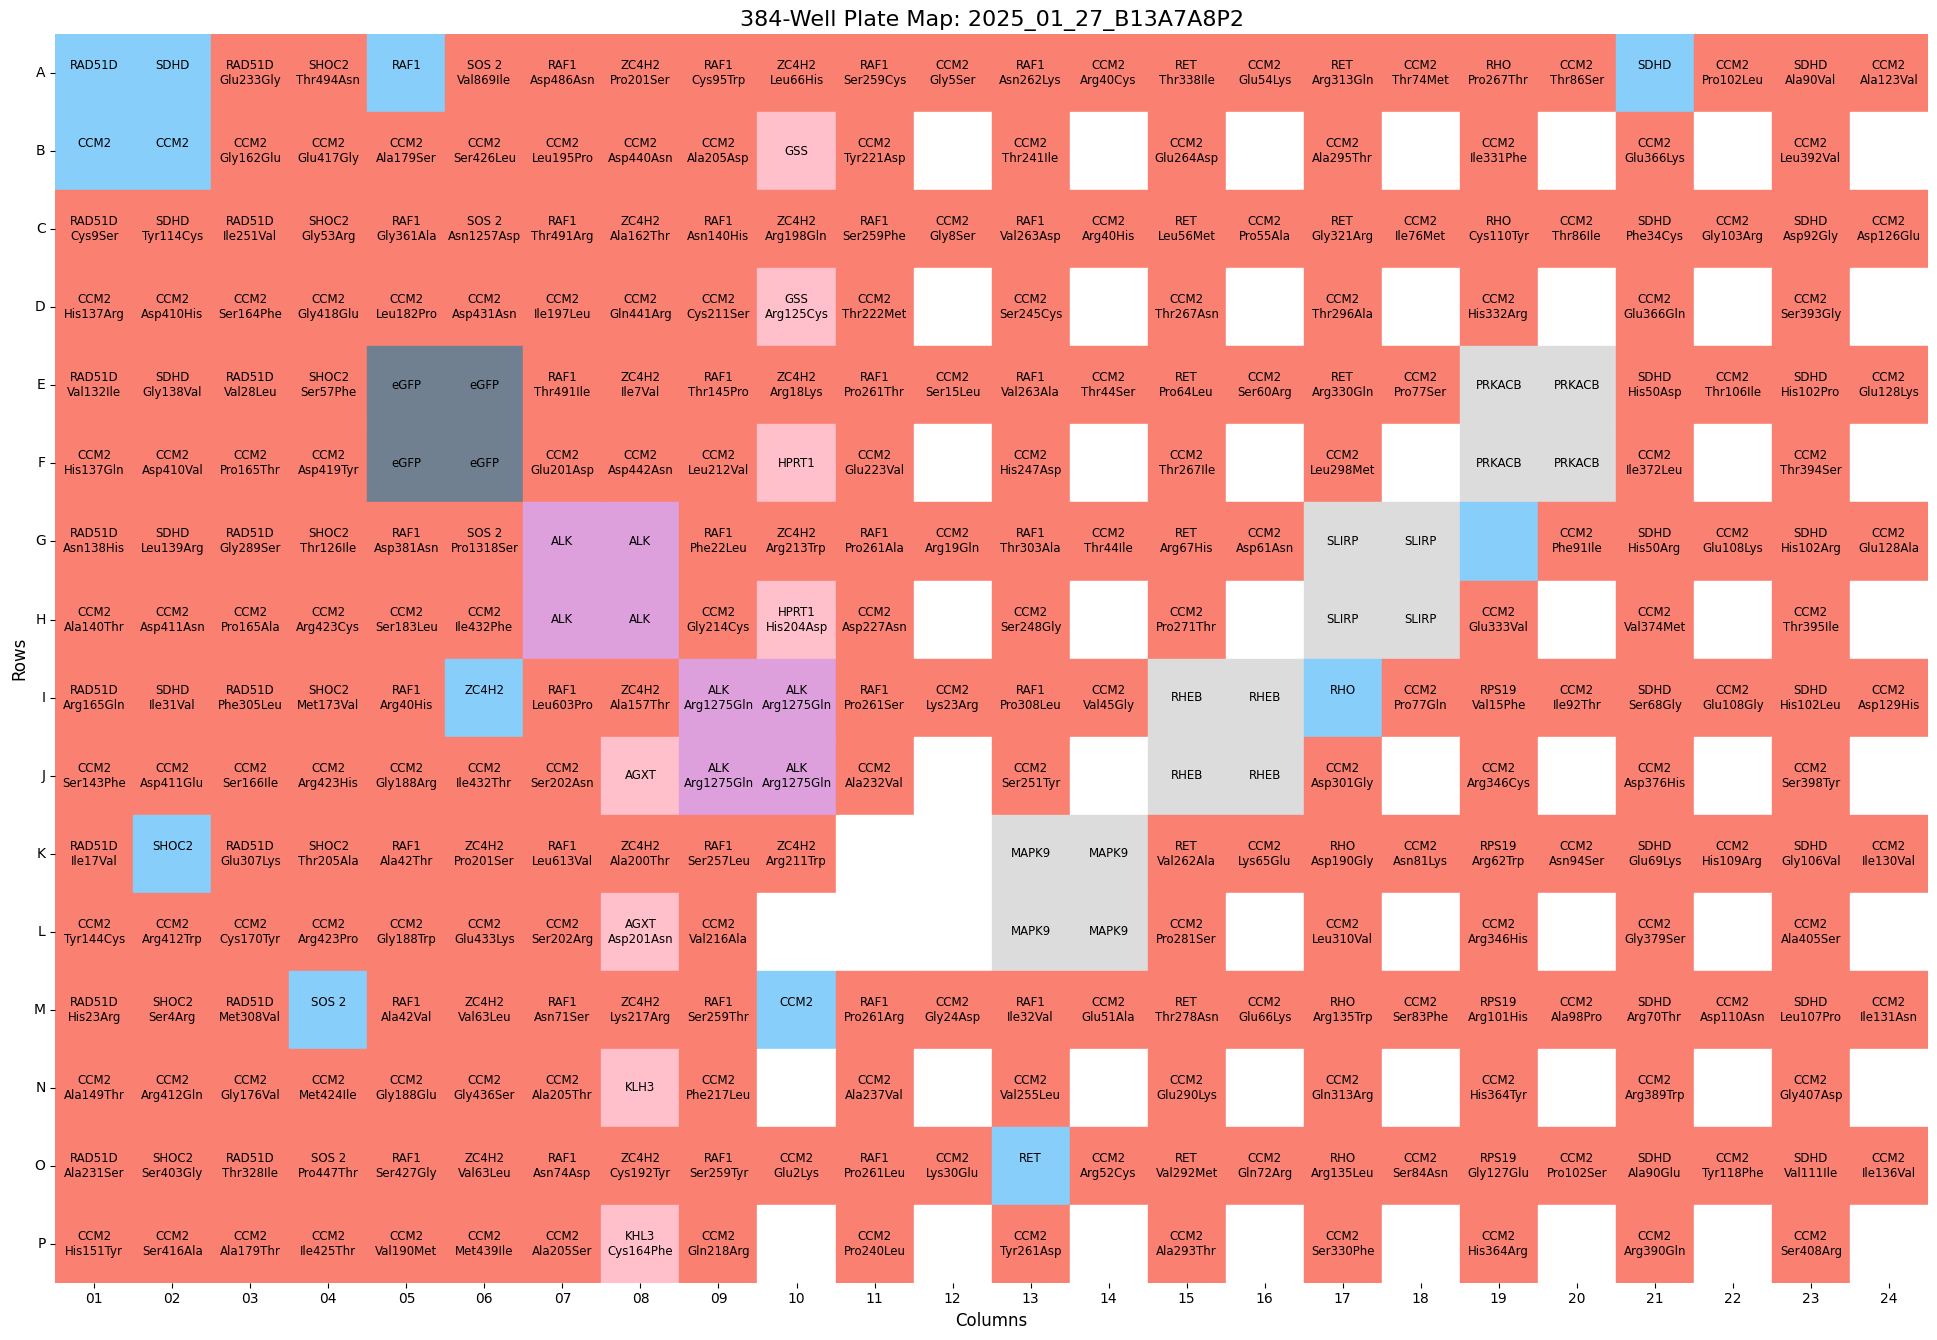

In [24]:
batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"

# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P2_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

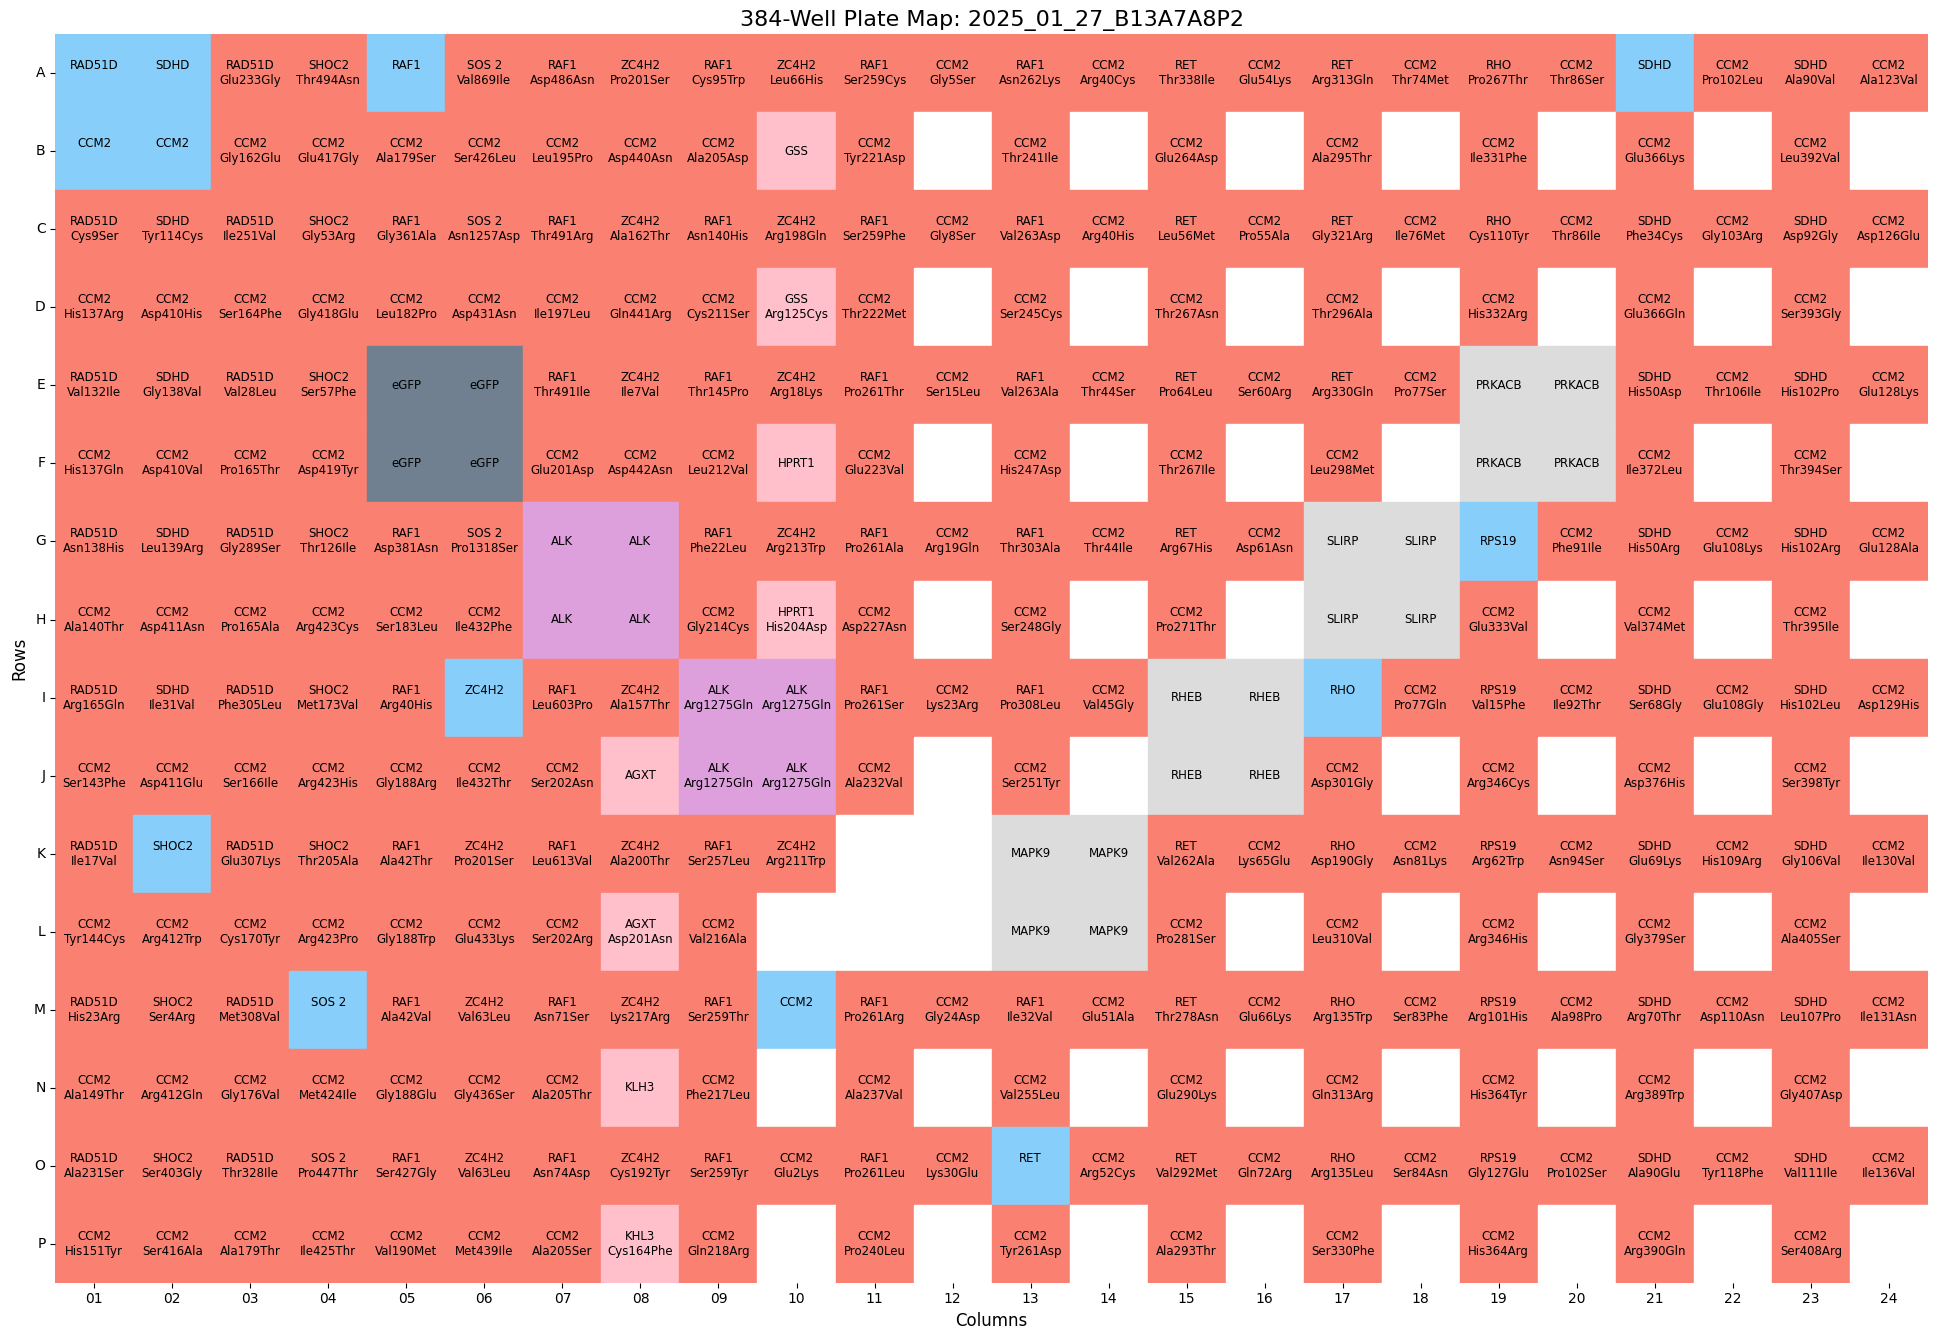

In [5]:
batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P2_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

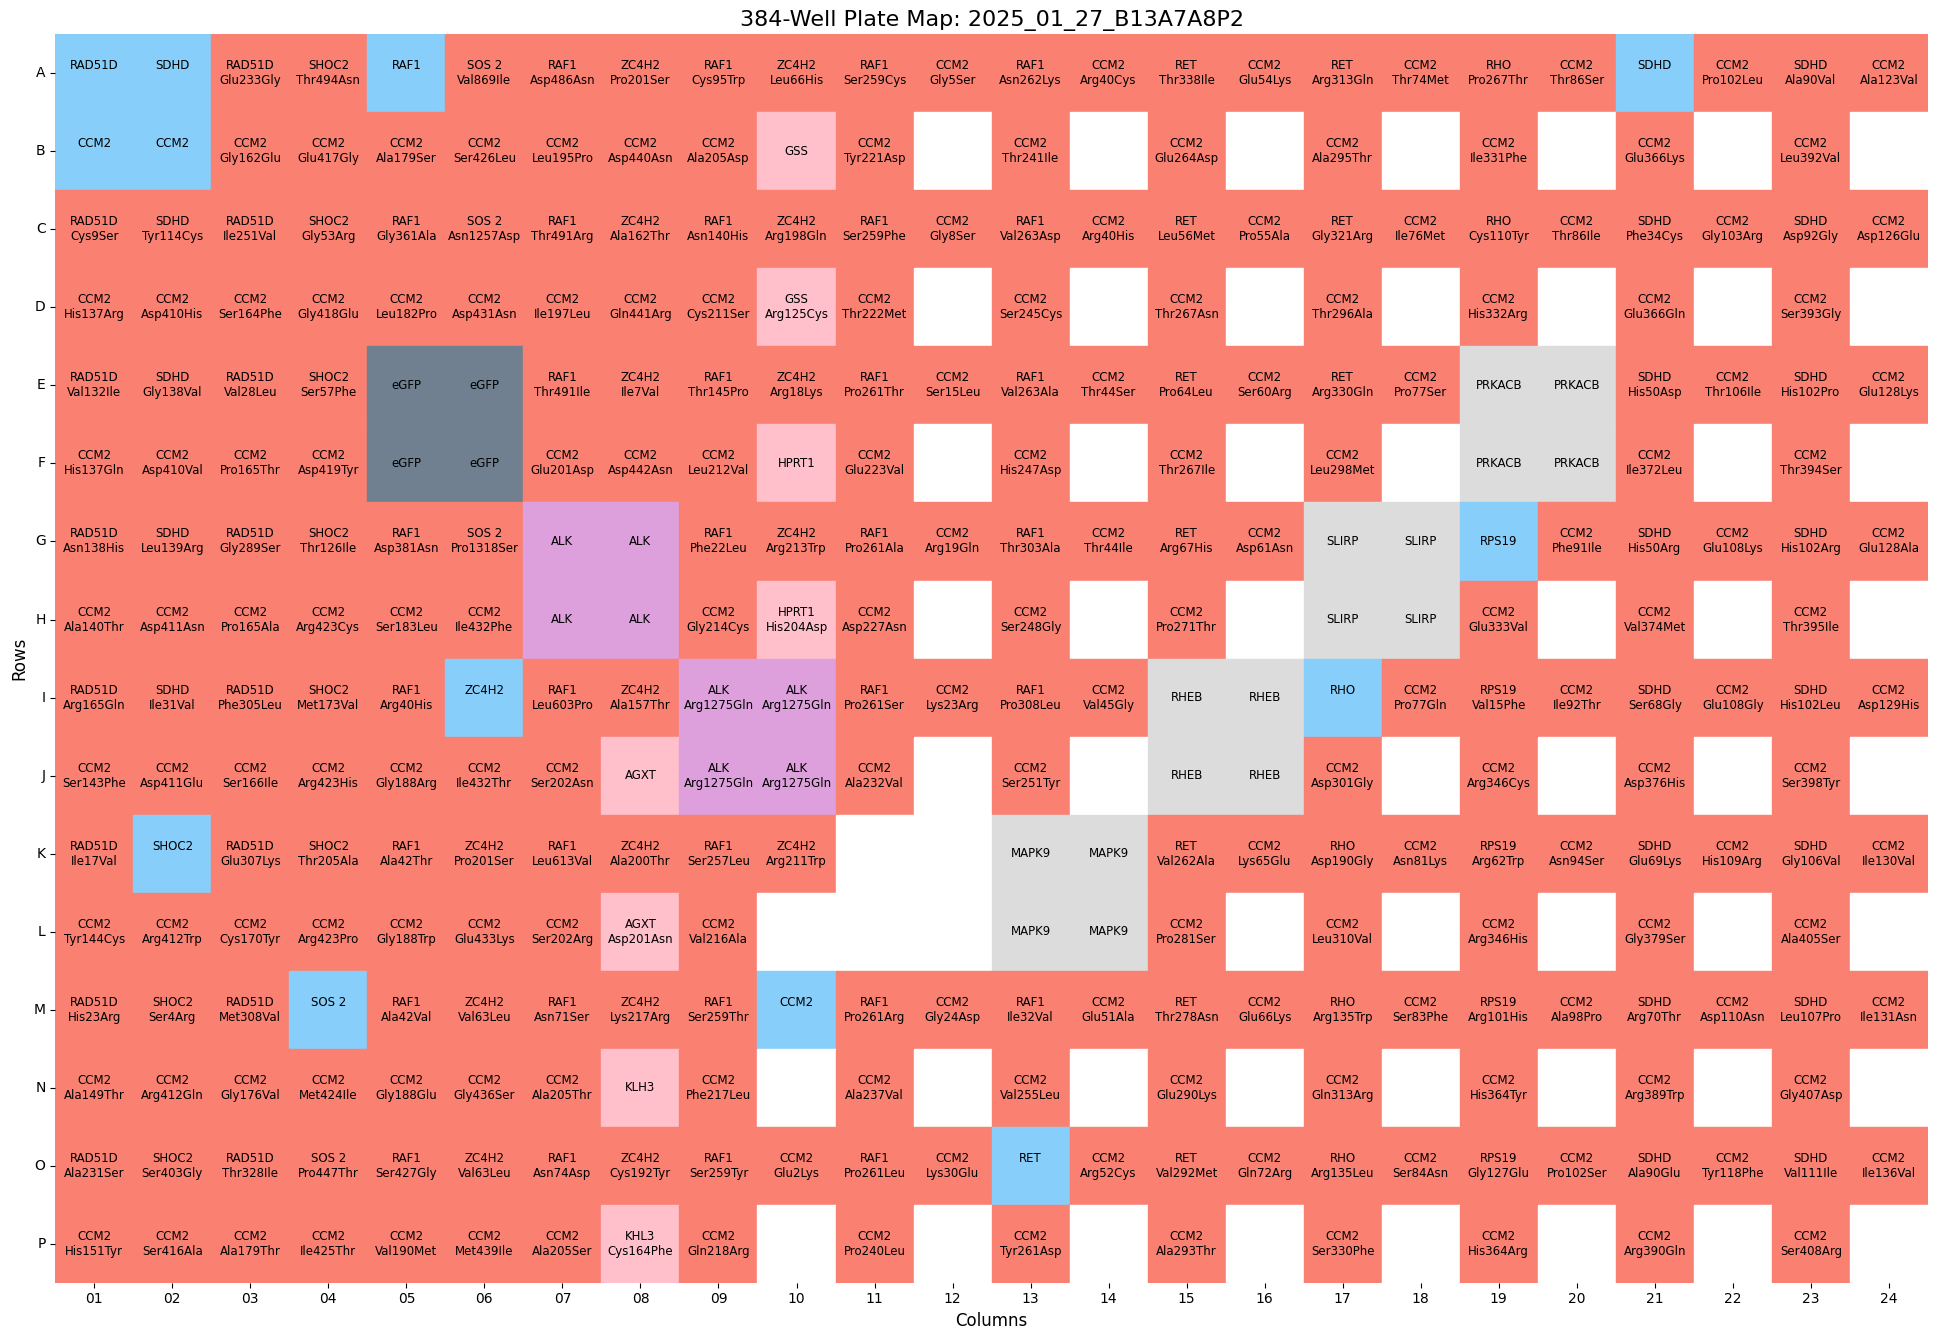

In [18]:
plate_map = plate_map.with_columns(
    # Condition 1: Keep "_" as is or fill the symbol if gene allele is missing by accident
    pl.when(pl.col("symbol").is_not_null()&pl.col("gene_allele").is_null())
        .then(pl.col("symbol"))
        .otherwise(pl.col("gene_allele"))
        .alias("gene_allele")
    # pl.when((pl.col("gene_allele")=="_")|(pl.col("gene_allele").is_null()&pl.col("symbol").is_not_null()))
    #     .then(pl.col("symbol"))
    #     .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
    #     .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
    #     .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
    #     .alias("gene_allele"),  # Replace the original column,
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.col("gene_allele"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
    #     .otherwise(pl.col("gene_allele"))
    #     .alias("symbol"),
    # pl.when(pl.col("aa_change").is_not_null()) ## manually handle a special case
    #     .then(pl.lit("allele"))
    #     .when((pl.col("node_type").is_null())&(pl.col("aa_change").is_null())&(pl.col("symbol").is_not_null())&(~pl.col("symbol").is_in(PC)))
    #     .then(pl.lit("disease_wt"))
    #     .when((pl.col("node_type").is_null())&(pl.col("symbol").is_in(PC)))
    #     .then(pl.lit("PC"))
    #     # .when(pl.col("node_type").is_not_null())
    #     # .then(pl.col("node_type"))
    #     .alias("control_type")
)
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

In [21]:
# plate_grid.filter(pl.col("well_position")=="G19")

In [22]:
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P2_T1.txt", separator="\t")

## Batch 9/10

### Confocal

Number of unique alleles: ['EGFP', 'F9_Glu27Lys', 'ALK_Arg1275Gln', 'PRKACB', 'LMNA', 'CTCF_Tyr226Cys', 'RPS19', 'RPS19_Val15Phe', 'CTCF_His455Gln', 'LMNA_Arg349Leu', 'G6PD_Glu398Lys', 'BCL10_Leu8Leu', 'F9_Glu73Val', 'G6PD', 'F9_Trp453Arg', 'FLCN_Arg239Cys', 'RPS19_Arg62Trp', 'LMNA_Arg331Pro', 'LMNA_Arg60Gly', 'FANCC_Asp195Val', 'LMNA_Glu186Lys', 'CTCF_Ala697Thr', 'F9_Pro333Leu', 'F9_Cys396Ser', '_', 'F9_Arg294Gln', 'RPS19_Arg101His', 'LMNA_Thr150Pro', 'F9_Ile256Thr', 'MRE11', 'MAPK9', 'F9_Cys170Tyr', 'F9_Gly357Arg', 'F9_Cys28Arg', 'CTCF_Arg342Cys', 'CTCF', 'CTCF_Asp46Asn', 'SLIRP', 'F9_Arg191His', 'F9_Cys268Trp', 'FANCC_Leu554Pro', 'CTCF_Glu590Gln', 'MRE11_Arg202Gly', 'LMNA_Tyr45Cys', 'LMNA_Ala132Pro', 'RPS19_Gly127Glu', 'CTCF_Arg342His', 'CTCF_Arg567Leu', 'CTCF_Arg342Gly', 'F9_Glu73Lys', 'CTCF_Tyr407Cys', 'F9_Arg384Pro', 'FANCC', 'F9_Arg226Gln', 'ALK', 'F9_Asp110Asn', 'LMNA_Arg541Ser', 'F9_Asp410His', 'LMNA_Gly232Glu', 'F9_His303Tyr', 'LMNA_Arg571Cys', 'F9_Asn306Ser', 'LMNA_Ala43Thr'

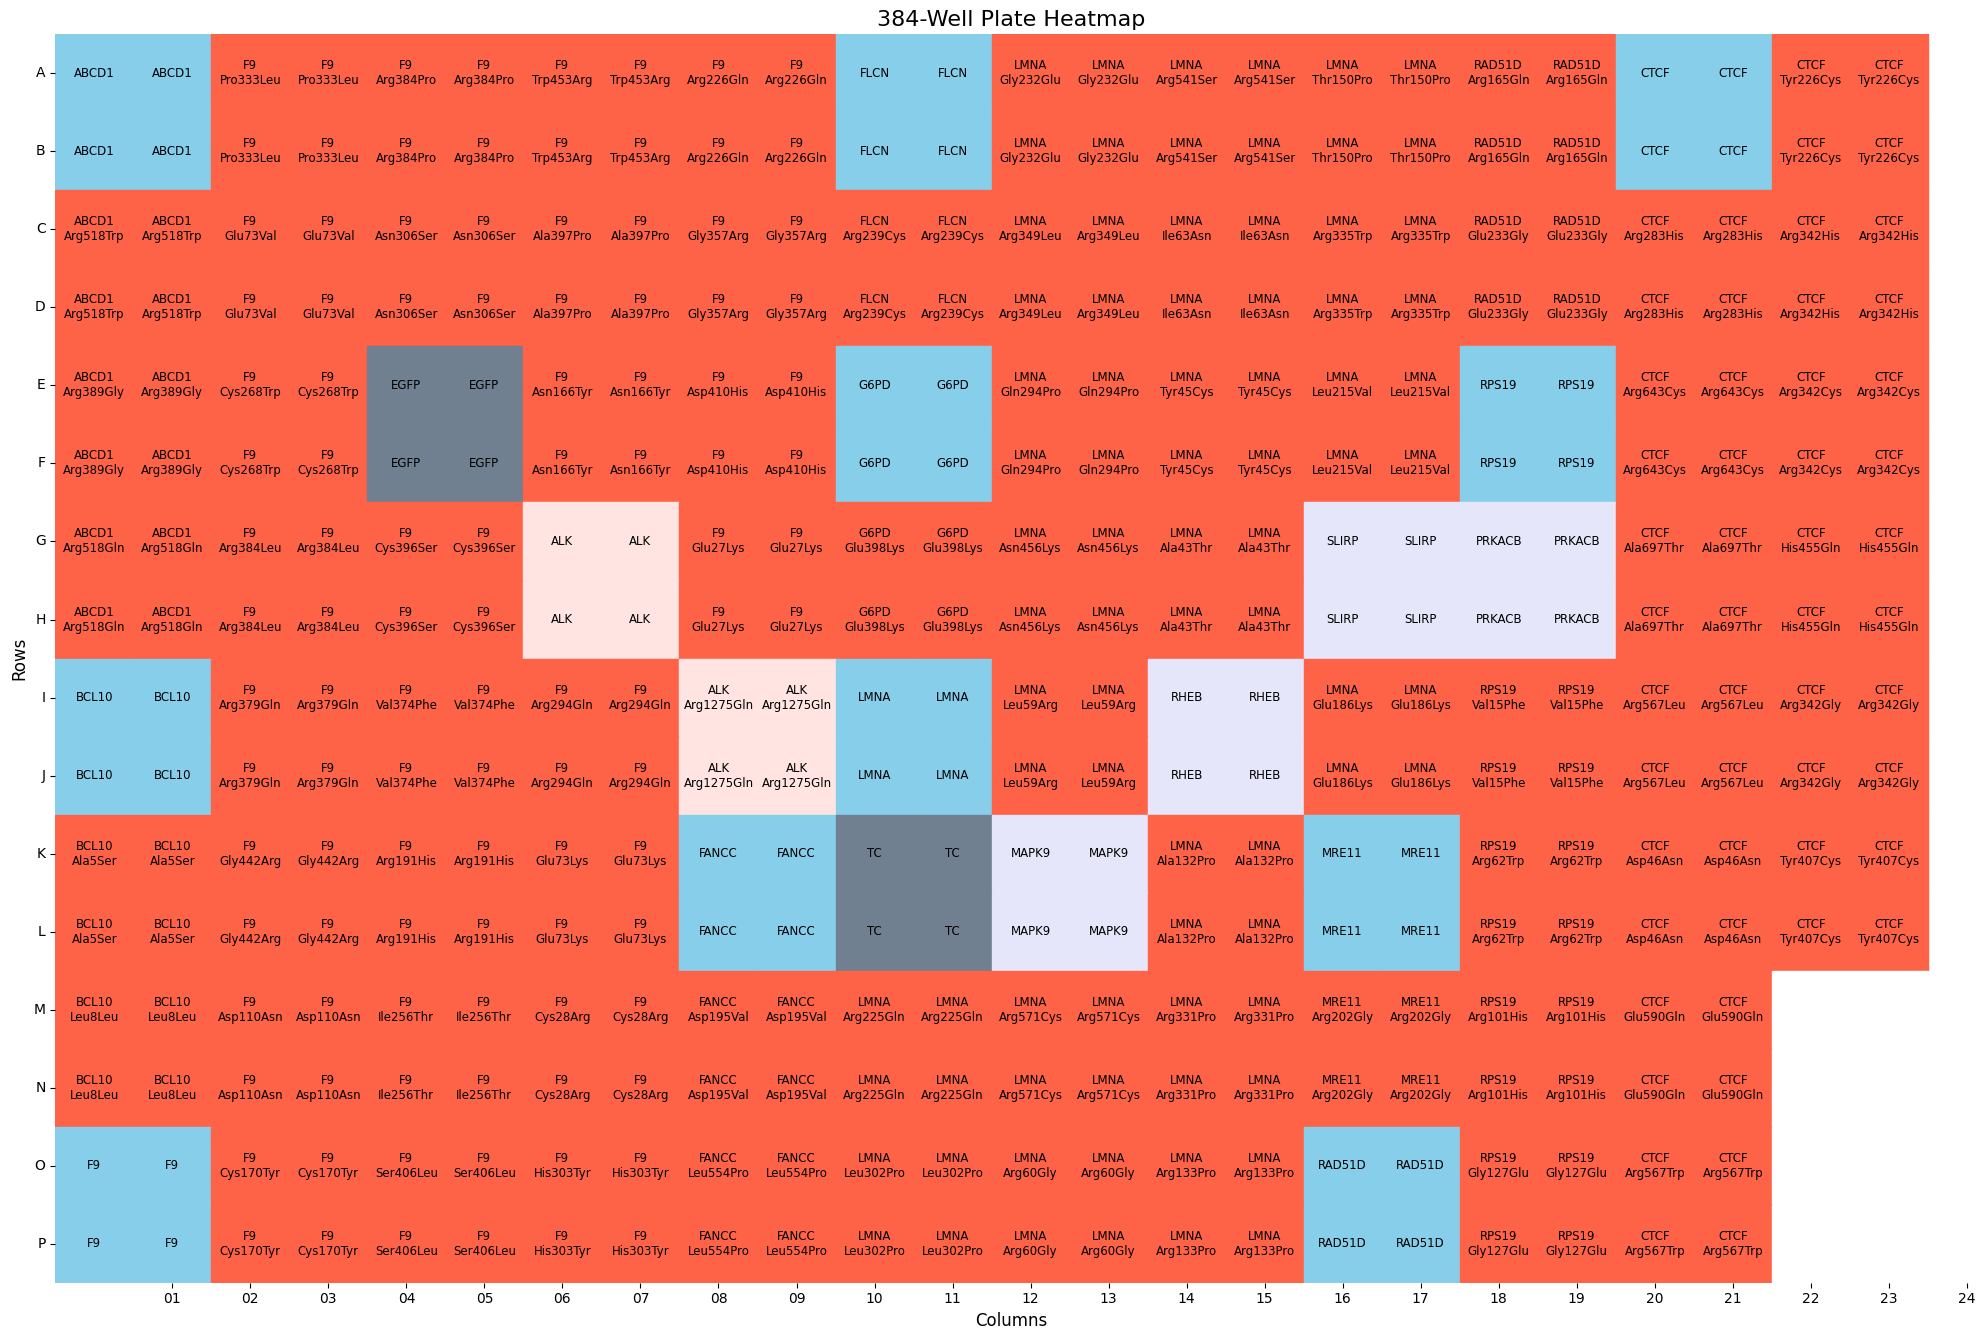

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg389Gly │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ CTCF      │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Tyr407Cys │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [36]:
batch9_platemap_confo = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_confocal/platemap"
plate_map_id = "B9A6R1_P01.txt"
plate_map = pl.read_csv(Path(batch9_platemap_confo) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(~pl.all_horizontal(pl.all().is_null()))
# print(plate_map.shape

column_name = "gene_allele"
plate_map = plate_map.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)

# print(plate_map.select(pl.col(column_name).unique()))
# print(plate_map.select(pl.col("gene_allele").unique()))
# # print(plate_map.select(pl.col("symbol").unique()))
plot_platemap(plate_map)

(236, 24)
Number of unique alleles: ['NF2_Lys206Glu', 'NF2_Met29Ile', 'ZC4H2_Arg211Trp', 'ALK', 'NF2_Ser489Gly', 'ZC4H2_Arg198Gln', '_', 'NF2_Asn220Tyr', 'ZC4H2_Lys217Arg', 'NF2_Asn92Ser', 'NF2_Met100Leu', 'ZC4H2_IIe7Val', 'NF2_Leu459Phe', 'NF2_Arg471Gly', 'ZC4H2_Ala200Thr', 'ZC4H2_Arg67Gln', 'NF2_Val136Met', 'NF2_Asp420Asn', 'NF2_Leu434Pro', 'NF2_Leu535Pro', 'EGFP', 'NF2_Leu315Pro', 'NF2_Thr336Arg', 'NF2_Glu111Asp', 'ZC4H2_Ala157Thr', 'NF2_Pro410Leu', 'ZC4H2_Val63Leu', 'NF2_Glu462Lys', 'ZC4H2_Leu66His', 'ALK_Arg1275Gln', 'NF2_Glu344Ala', None, 'NF2_Gly157Glu', 'NF2_Arg335Cys', 'NF2_Leu58Pro', 'NF2_Asp411His', 'NF2_Arg418Cys', 'NF2_Lys186Glu', 'ZC4H2_Ala162Thr', 'NF2_Leu277Pro', 'NF2_Pro19Arg', 'ZC4H2_Cys192Tyr', 'NF2_Leu131Pro', 'NF2_Gln64Pro', 'NF2_Arg8Ser', 'ZC4H2', 'ZC4H2_Pro201Ser', 'NF2_Thr189Ile', 'NF2_Asn36Ser', 'NF2_Leu375Arg', 'MAPK9', 'NF2', 'ZC4H2_Arg18Lys', 'NF2_His479Arg', 'ZC4H2_Arg213Trp']


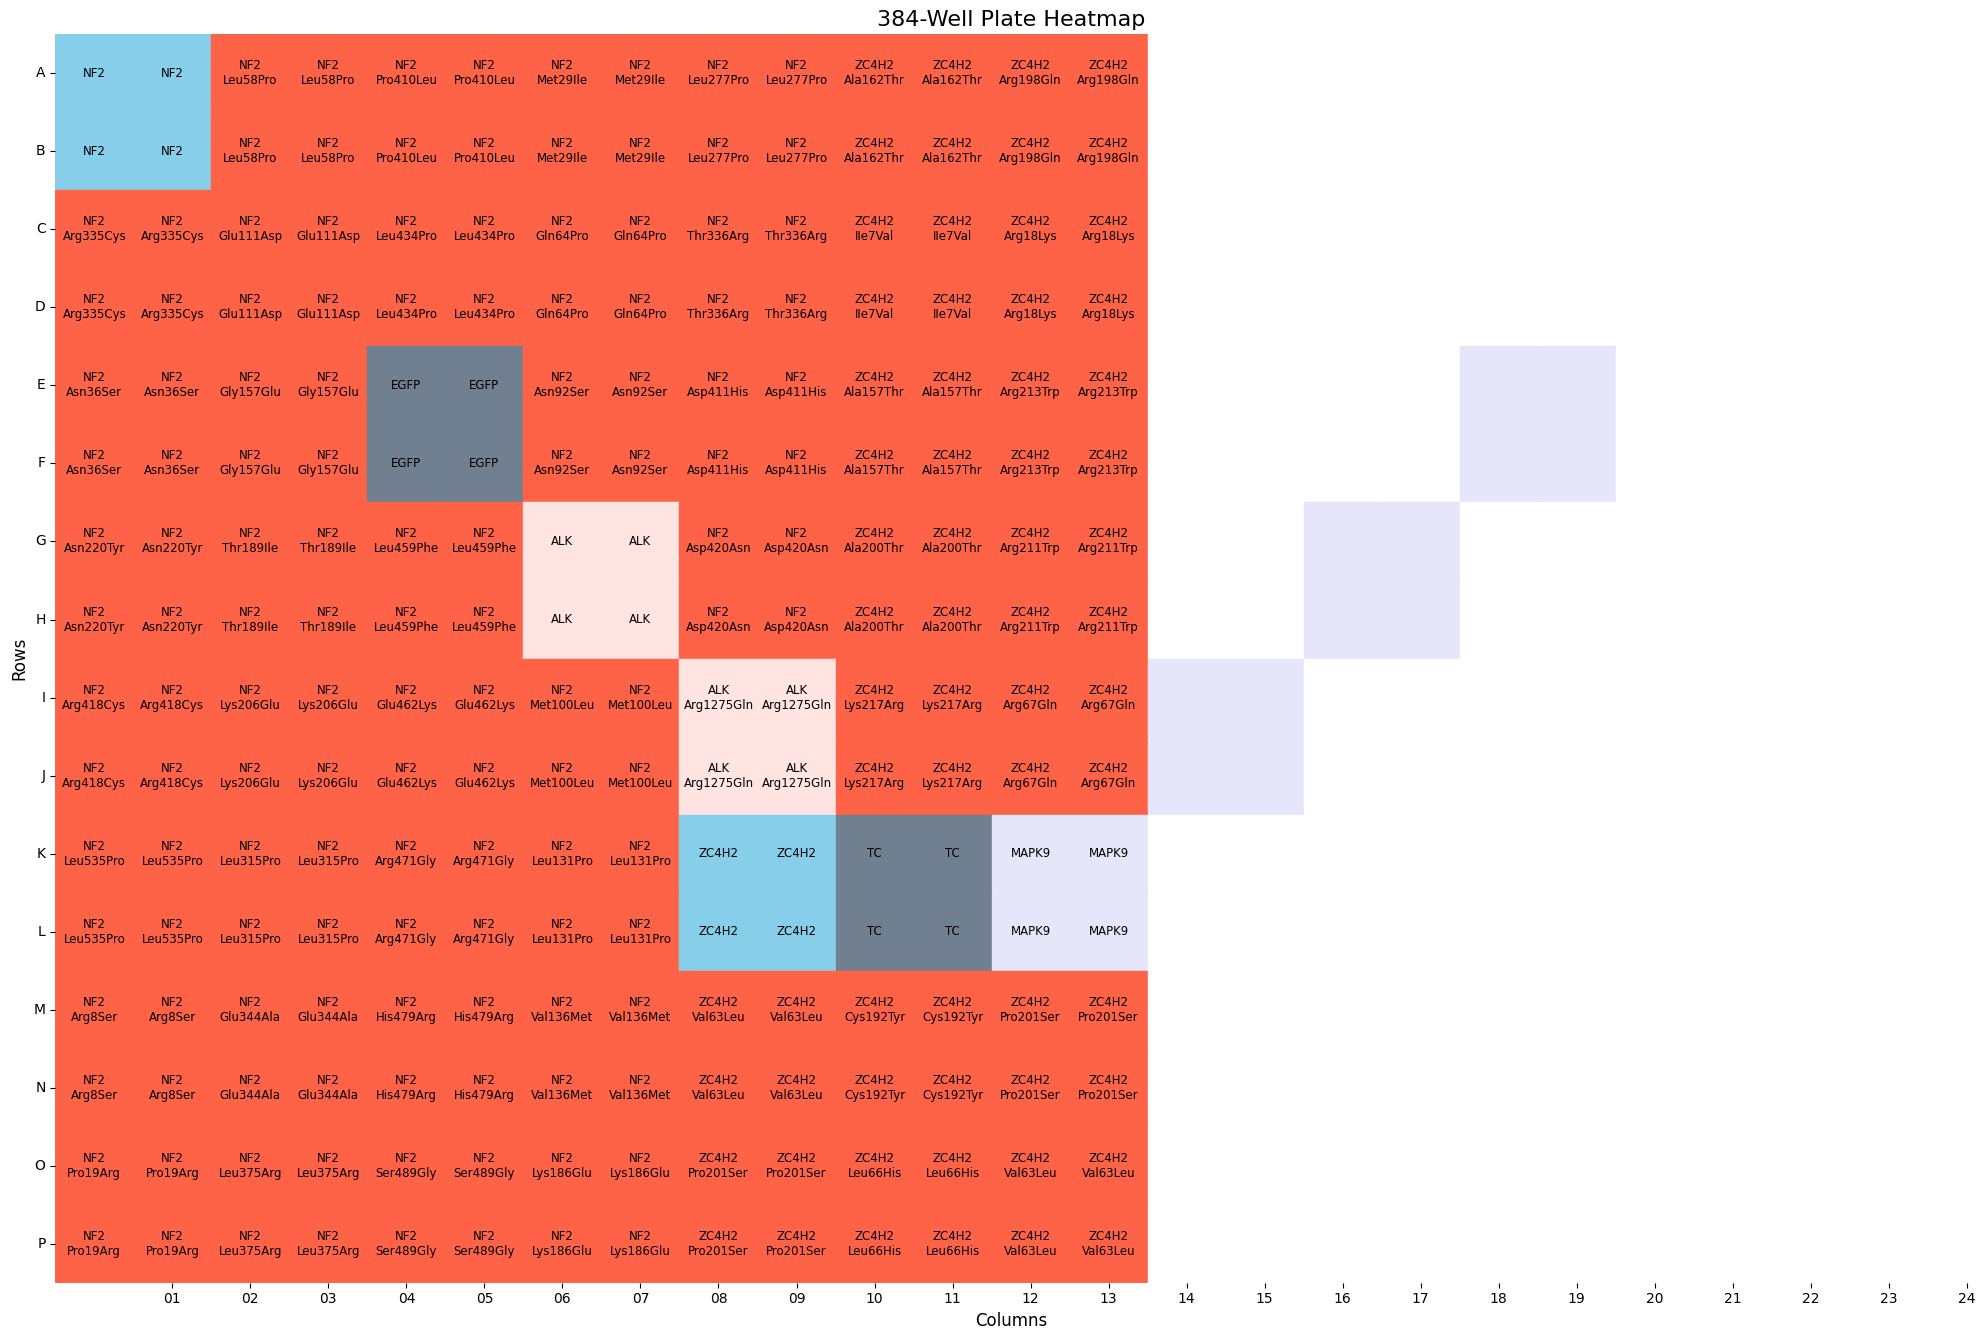

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ NF2       │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ NF2       │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg335Cys │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg335Cys │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Asn36Ser  │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [37]:
batch9_platemap_confo = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_confocal/platemap"
plate_map_id2 = "B9A6R1_P02.txt"
plate_map_2 = pl.read_csv(Path(batch9_platemap_confo) / Path(plate_map_id2), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map_2 = plate_map_2.filter(~pl.all_horizontal(pl.all().is_null()))
print(plate_map_2.shape)
plate_map_2 = plate_map_2.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
)
plot_platemap(plate_map_2)

(376, 24)
Number of unique alleles: ['F9_Asp410His', 'RPS19_Gly127Glu', 'F9_Arg379Gln', 'F9_Arg384Pro', 'PRKACB', 'CTCF_Arg342Gly', 'F9_Cys28Arg', 'FLCN', 'F9_Arg384Leu', 'LMNA_Arg349Leu', 'RAD51D_Arg165Gln', 'G6PD_Glu398Lys', 'BCL10', 'F9_Arg191His', 'CTCF_Tyr407Cys', 'LMNA_Arg331Pro', 'F9_Val374Phe', 'LMNA_Arg133Pro', 'MRE11', 'CTCF_Tyr226Cys', 'ABCD1_Arg389Gly', 'ABCD1_Arg518Gln', 'F9_Asp110Asn', 'F9_Asn306Ser', 'RAD51D', 'F9_His303Tyr', 'SLIRP', 'ABCD1', 'MAPK9', 'CTCF_Arg342Cys', 'F9_Glu27Lys', 'LMNA_Asn456Lys', 'RPS19_Arg101His', 'LMNA_Gly232Glu', 'LMNA_Leu59Arg', 'RPS19_Val15Phe', 'FLCN_Arg239Cys', 'F9_Gly442Arg', 'ABCD1_Arg518Trp', 'CTCF_Glu590Gln', 'F9_Trp453Arg', 'G6PD', 'FANCC', 'F9_Arg294Gln', 'BCL10_Ala5Ser', 'RAD51D_Glu233Gly', 'LMNA_Thr150Pro', 'CTCF_Arg342His', 'LMNA_Ala43Thr', 'F9_Glu73Val', 'CTCF', 'BCL10_Leu8Leu', 'F9_Ile256Thr', 'RHEB', 'F9_Asn166Tyr', 'F9_Ser406Leu', 'CTCF_Arg567Leu', 'FANCC_Asp195Val', 'FANCC_Leu554Pro', 'F9', 'EGFP', 'CTCF_Arg567Trp', 'LMNA_Glu18

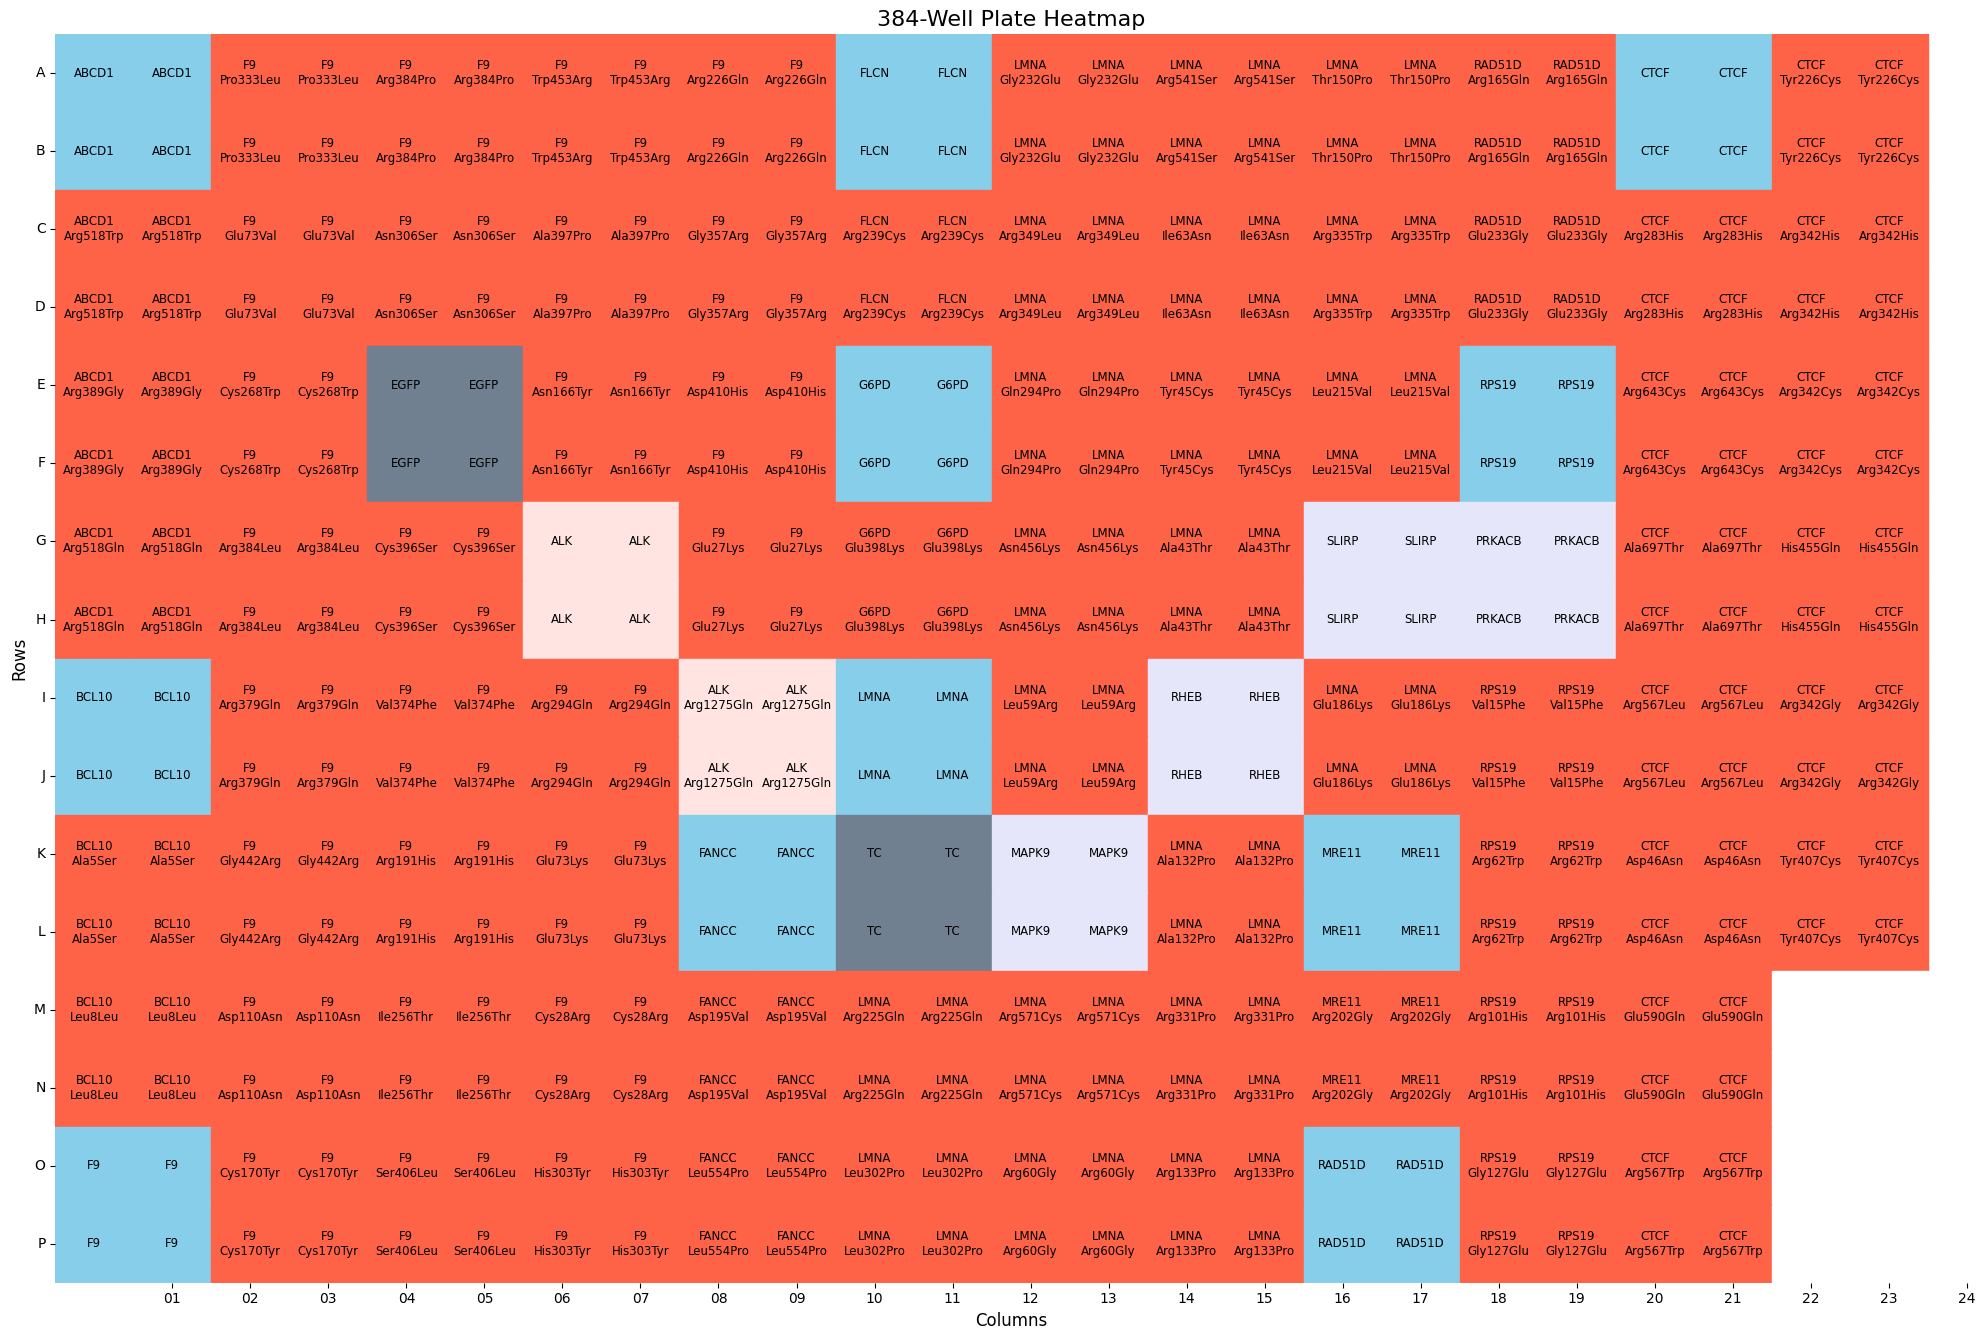

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg389Gly │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ CTCF      │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Tyr407Cys │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [42]:
batch9_platemap_wf = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_widefield/platemap"
plate_map_id2 = "B9A6R1_P01_widefield.txt"
plate_map_2 = pl.read_csv(Path(batch9_platemap_wf) / Path(plate_map_id2), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map_2 = plate_map_2.filter(~pl.all_horizontal(pl.all().is_null()))
print(plate_map_2.shape)
column_name = "gene_allele"
plate_map_2 = plate_map_2.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)
# plate_map
# print(plate_map.select(pl.col(column_name).unique()))
# print(plate_map.select(pl.col("gene_allele").unique()))
# # print(plate_map.select(pl.col("symbol").unique()))
plot_platemap(plate_map_2)

In [193]:
# batch10_platemap_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_10_widefield/platemap"
# plate_map_id = "B10A6R2_P01_widefield.txt"
# plate_map = pl.read_csv(Path(batch10_platemap_dir) / Path(plate_map_id), separator='\t', has_header=True)
# plate_map = plate_map.drop_nulls()
# plate_map = plate_map.with_columns(pl.col("node_type").alias("control_type"))
# plot_platemap(plate_map)

## Batch 7/8

shape: (92, 1)
┌────────┐
│ symbol │
│ ---    │
│ str    │
╞════════╡
│ CTRC   │
│ BTC    │
│ EZH2   │
│ RHEB   │
│ ACY1   │
│ …      │
│ COL2A1 │
│ ANKRD1 │
│ ADIPOQ │
│ CREB1  │
│ AGXT   │
└────────┘


shape: (384, 30)
┌───────────┬───────────┬───────────┬─────────┬───────────┬───┬─────┬─────┬──────┬──────┬──────────┐
│ plate_map ┆ well_posi ┆ control_t ┆ symbol  ┆ gene_alle ┆ … ┆ c96 ┆ r96 ┆ r384 ┆ c384 ┆ r384_let │
│ _name     ┆ tion      ┆ ype       ┆ ---     ┆ le        ┆   ┆ --- ┆ --- ┆ ---  ┆ ---  ┆ ter      │
│ ---       ┆ ---       ┆ ---       ┆ str     ┆ ---       ┆   ┆ i64 ┆ i64 ┆ i64  ┆ i64  ┆ ---      │
│ str       ┆ str       ┆ str       ┆         ┆ str       ┆   ┆     ┆     ┆      ┆      ┆ str      │
╞═══════════╪═══════════╪═══════════╪═════════╪═══════════╪═══╪═════╪═════╪══════╪══════╪══════════╡
│ B7A1R1_P1 ┆ A01       ┆ disease_w ┆ ACSF3   ┆ ACSF3     ┆ … ┆ 1   ┆ 1   ┆ 1    ┆ 1    ┆ A        │
│           ┆           ┆ t         ┆         ┆           ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ C01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ala ┆ … ┆ 1   ┆ 2   ┆ 3    ┆ 1    ┆ C        │
│           ┆           ┆           ┆         ┆ 197Thr    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ E01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Thr ┆ … ┆ 1   ┆ 3   ┆ 5    ┆ 1    ┆ E        │
│           ┆           ┆           ┆         ┆ 358Ile    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ G01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Met ┆ … ┆ 1   ┆ 4   ┆ 7    ┆ 1    ┆ G        │
│           ┆           ┆           ┆         ┆ 198Arg    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ I01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Glu ┆ … ┆ 1   ┆ 5   ┆ 9    ┆ 1    ┆ I        │
│           ┆           ┆           ┆         ┆ 359Lys    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ K01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ile ┆ … ┆ 1   ┆ 6   ┆ 11   ┆ 1    ┆ K        │
│           ┆           ┆           ┆         ┆ 200Met    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ M01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ser ┆ … ┆ 1   ┆ 7   ┆ 13   ┆ 1    ┆ M        │
│           ┆           ┆           ┆         ┆ 431Tyr    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ O01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Gly ┆ … ┆ 1   ┆ 8   ┆ 15   ┆ 1    ┆ O        │
│           ┆           ┆           ┆         ┆ 225Arg    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ A03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Asp ┆ … ┆ 2   ┆ 1   ┆ 1    ┆ 3    ┆ A        │
│           ┆           ┆           ┆         ┆ 457Asn    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ C03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Arg ┆ … ┆ 2   ┆ 2   ┆ 3    ┆ 3    ┆ C        │
│           ┆           ┆           ┆         ┆ 10Trp     ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ E03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Asp ┆ … ┆ 2   ┆ 3   ┆ 5    ┆ 3    ┆ E        │
│           ┆           ┆           ┆         ┆ 236Asn    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ G03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Arg ┆ … ┆ 2   ┆ 4   ┆ 7    ┆ 3    ┆ G        │
│           ┆           ┆           ┆         ┆ 471Trp    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ I03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Pro ┆ … ┆ 2   ┆ 5   ┆ 9    ┆ 3    ┆ I        │
│           ┆           ┆           ┆         ┆ 243Leu    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ K03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Gly ┆ … ┆ 2   ┆ 6   ┆ 11   ┆ 3    ┆ K        │
│           ┆           ┆           ┆         ┆ 119Asp    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ M03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Met ┆ … ┆ 2   ┆ 7   ┆ 13   ┆ 3    ┆ M        │
│           ┆           ┆           ┆         ┆ 266Val    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ O03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Pro ┆ … ┆ 2   ┆ 8   ┆ 15   ┆ 3    ┆ O        │
│           ┆           ┆           ┆         ┆ 285Leu    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ A05       ┆ allele    ┆ ACSF3   ┆ ACSF3_Glu ┆ … ┆ 3   ┆ 1   ┆ 1    ┆ 5    ┆ A        │
│           ┆           ┆           ┆       

Number of unique alleles: ['AGXT_Met49Leu', 'ALAS2_Asp122Asn', 'ACSF3_Ile200Met', 'DES_Thr453Ile', 'DES_Met349Ile', 'AGXT_Arg301Cys', 'DES_Ala135Val', 'ADIPOQ', 'AGXT', 'AIPL1_Thr114Ile', 'AQP1', 'ACSF3', 'COMP_Asp319Val', 'AGXT_Ala186Val', 'CORO1A', 'ACSF3_Ser431Tyr', 'CYP21A2', 'AGXT_Ala85Asp', 'ALAS2_Ala135Thr', 'AGXT_Asp341Glu', 'ALAS2', 'COMP_Asp408Asn', 'DES_Ser46Tyr', 'BRIP1', 'EFHC1_Ile174Val', 'ALOX5', 'CTRC_Glu225Ala', 'AGXT_Arg197Gln', 'AGXT_Ala248Val', 'AIPL1_Met79Thr', 'CRYAB_Gly154Ser', 'AGXT_Asp129His', 'APOA1_Ala199Pro', 'EMD_Asp72Val', 'CBR3', 'ACSF3_Gly225Arg', 'DCX_Lys174Glu', 'AGXT_Ile202Asn', 'DES_Val56Leu', 'APOA1_Trp74Arg', 'AGXT_Leu298Pro', 'AGXT_Met195Leu', 'COMP_Thr585Met', 'DMC1', 'DCX_Arg89Gly', 'BLMH_Ile443Val', 'DES_Tyr331Asn', 'AMPD2', 'ACSF3_Arg558Trp', 'FADD_Cys105Trp', 'EMD_Met1Val', 'EIF2B4', 'ALAS2_Phe128Leu', 'DES_Pro433Thr', 'ACSF3_Ala197Thr', 'AGXT_Gly161Arg', 'DES_Gln389Pro', 'ACSF3_Arg471Trp', 'AGXT_Ser221Pro', 'EIF2B4_Ala228Val', 'ANKRD1', 'CLD

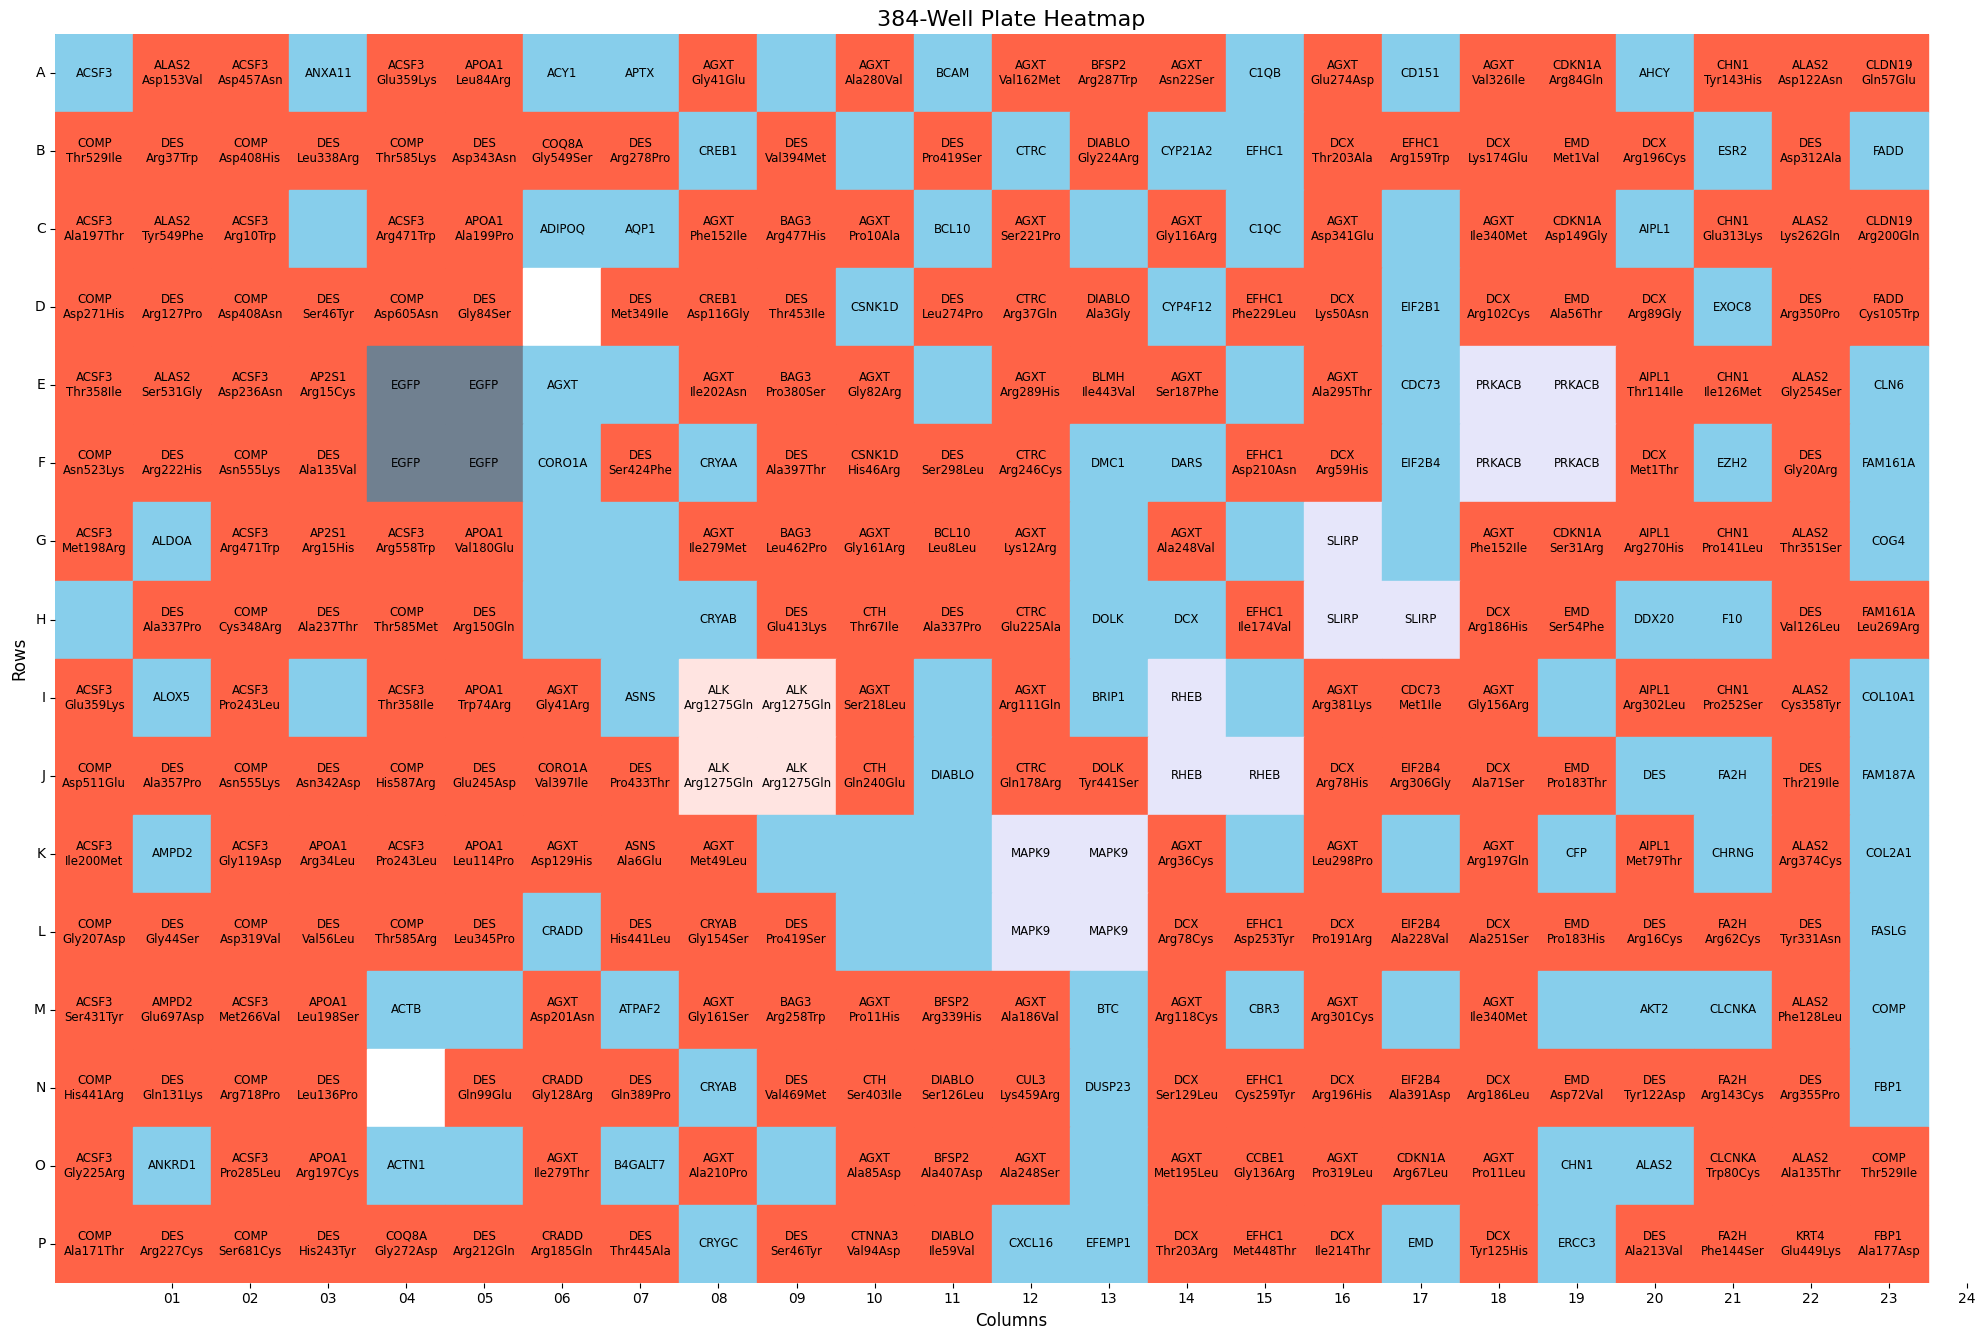

shape: (384, 37)
┌─────┬─────┬───────┬───────────┬───────────┬───┬──────┬──────┬────────────┬───────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ col_label ┆ … ┆ r384 ┆ c384 ┆ r384_lette ┆ color     ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ r          ┆ ---       ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆ str       ┆   ┆ i64  ┆ i64  ┆ ---        ┆ str       ┆ str       │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆ str        ┆           ┆           │
╞═════╪═════╪═══════╪═══════════╪═══════════╪═══╪══════╪══════╪════════════╪═══════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ 01        ┆ … ┆ 1    ┆ 1    ┆ A          ┆ disease_w ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆ t         ┆           │
│ 1   ┆ 01  ┆       ┆ B         ┆ 01        ┆ … ┆ 2    ┆ 1    ┆ B          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Thr529Ile │
│ 2   ┆ 01  ┆       ┆ C         ┆ 01        ┆ … ┆ 3    ┆ 1    ┆ C          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ala197Thr │
│ 3   ┆ 01  ┆       ┆ D         ┆ 01        ┆ … ┆ 4    ┆ 1    ┆ D          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asp271His │
│ 4   ┆ 01  ┆       ┆ E         ┆ 01        ┆ … ┆ 5    ┆ 1    ┆ E          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Thr358Ile │
│ 5   ┆ 01  ┆       ┆ F         ┆ 01        ┆ … ┆ 6    ┆ 1    ┆ F          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asn523Lys │
│ 6   ┆ 01  ┆       ┆ G         ┆ 01        ┆ … ┆ 7    ┆ 1    ┆ G          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Met198Arg │
│ 7   ┆ 01  ┆       ┆ H         ┆ 01        ┆ … ┆ 8    ┆ 1    ┆ H          ┆ disease_w ┆           │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆ t         ┆           │
│ 8   ┆ 01  ┆       ┆ I         ┆ 01        ┆ … ┆ 9    ┆ 1    ┆ I          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Glu359Lys │
│ 9   ┆ 01  ┆       ┆ J         ┆ 01        ┆ … ┆ 10   ┆ 1    ┆ J          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asp511Glu │
│ 10  ┆ 01  ┆       ┆ K         ┆ 01        ┆ … ┆ 11   ┆ 1    ┆ K          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ile200Met │
│ 11  ┆ 01  ┆       ┆ L         ┆ 01        ┆ … ┆ 12   ┆ 1    ┆ L          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Gly207Asp │
│ 12  ┆ 01  ┆       ┆ M         ┆ 01        ┆ … ┆ 13   ┆ 1    ┆ M          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ser431Tyr │
│ 13  ┆ 01  ┆       ┆ N         ┆ 01        ┆ … ┆ 14   ┆ 1    ┆ N          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ His441Arg │
│ 14  ┆ 01  ┆       ┆ O         ┆ 01        ┆ … ┆ 15   ┆ 1    ┆ O          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Gly225Arg │
│ 15  ┆ 01  ┆       ┆ P         ┆ 01        ┆ … ┆ 16   ┆ 1    ┆ P          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ala171Thr │
│ 0   ┆ 02  ┆       ┆ A         ┆ 02        ┆ … ┆ 1    ┆ 2    ┆ A          ┆ allele    ┆ ALAS2     │
│     ┆     ┆       ┆           ┆           

In [45]:
batch7_platemap_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch78/2024_01_23_Batch_7"
plate7_map_id = "B7A1R1_P1.txt"
plate7_map = pl.read_csv(Path(batch7_platemap_dir) / Path(plate7_map_id), separator='\t', has_header=True)
print(plate7_map.select(pl.col("symbol").unique()))

pl.Config.set_tbl_rows(200)  # Show all rows
pl.Config.set_tbl_cols(10)  # Show all columns
display(plate7_map)
# print("Number of unique alleles:", plate7_map.select(pl.col("gene_allele").unique()))
plate7_map.head() #  = plate_map.drop_nulls()
# print(plate7_map.filter(pl.col("symbol").is_in(TC+NC+PC+cNC+cPC) | pl.col("gene_allele").is_in(TC+NC+PC+cNC+cPC)))
# print(plate7_map.filter(pl.col("symbol").is_in(TC+NC+PC+cNC+cPC)))
plot_platemap(plate7_map)

In [4]:
# def check_batch_pms(batch_dir):
#     platemap_set = sorted(set([platemap_id.split('_T')[0] for platemap_id in os.listdir(batch_dir)]))
#     print("Platemaps available for batch:", platemap_set)
#     for platemap_id in platemap_set:
#         pm_ref_df = pl.read_csv(Path(batch_dir) / Path(platemap_id+"_T1.txt"), separator='\t', has_header=True)
#         columns_to_include = pm_ref_df.columns[1:]
#         for pm_file in [pm for pm in os.listdir(batch_dir) if platemap_id in pm and "T1" not in pm]:
#             pm_df = pl.read_csv(Path(batch_dir) / Path(pm_file), separator='\t', has_header=True)
#             df1_selected = pm_ref_df.select(columns_to_include)
#             df2_selected = pm_df.select(columns_to_include)
#             assert df1_selected.equals(df2_selected)
#             print(f"{pm_file} is equal to ref. {platemap_id}_T1.txt")